To get data and notebook with outputs, see:

https://github.com/Bruno-Limon/EPR-model-comparison

# **<font color="#ffb94f">0.0 PREPARATION</font>**

## **<font color="#84f745">0.1 IMPORTS & NOTEBOOK SETUP</font>**

In [1]:
# In case of running on Google Colab
%%capture
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
import os
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!pip install rtree
!ldconfig
!pip install scikit-mobility

!pip install geovoronoi
# Specifying pandas' version to overcome issue with 'TrajDataFrame' object has no attribute '_crs' during preprocessing phase
!pip install pandas==1.5.3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import random

import skmob
from skmob.tessellation import tilers
from skmob.models.epr import DensityEPR, SpatialEPR, Ditras
from skmob.models.markov_diary_generator import MarkovDiaryGenerator
from skmob.preprocessing import filtering, compression, detection, clustering
from skmob.measures.individual import jump_lengths, radius_of_gyration, uncorrelated_entropy, number_of_locations, number_of_visits, location_frequency
from skmob.measures.collective import visits_per_location
from skmob.utils.plot import *
from skmob.data.load import load_dataset, list_datasets
from shapely.geometry import MultiPolygon, Polygon, Point
from shapely.ops import unary_union

import sklearn
from sklearn.metrics import mean_squared_error

from scipy.stats import gaussian_kde, iqr
from scipy.spatial import Voronoi,voronoi_plot_2d
from geovoronoi import voronoi_regions_from_coords, points_to_coords

In [3]:
# Setting up plot style
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":16,"axes.labelsize":14})
sns.set_style("whitegrid", {'grid.linestyle': '--', 'alpha': 0.25})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})

In [4]:
np.seterr(divide = 'ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## **<font color="#84f745">0.2 FUNCTIONS</font>**

In [5]:
# Function to obtain the distributions Mi, i in {1...6}
def compute_measures(Traj):
    m1 = jump_lengths(Traj, show_progress = False, merge=True)
    m1 = [m for m in m1 if m >= 1]

    m2 = list(radius_of_gyration(Traj, show_progress = False)['radius_of_gyration']) 
    m2 = [m for m in m2 if m >= 1]

    m3 = list(uncorrelated_entropy(Traj, show_progress = False)['uncorrelated_entropy']) 
    m3 = [m for m in m3 if m > 0]

    m4 = list(number_of_locations(Traj, show_progress = False)['number_of_locations']) 
    m4 = [m for m in m4 if m > 0]

    m5 = list(visits_per_location(Traj)['n_visits'])
    m5 = [m for m in m5 if m > 0]

    m6 = location_frequency(Traj, as_ranks = True, show_progress = False)
    m6 = [m for m in m6 if m > 0]

    list_measures = [m1, m2, m3, m4, m5, m6]
    list_min = []
    list_max = []
    list_avg = []
    list_std = []

    # Stats for previously computed measures
    for m in list_measures:
        list_min.append(round(min(m),4)) 
        list_max.append(round(max(m),4))
        list_avg.append(round(np.mean(m),4))
        list_std.append(round(np.std(m),4))

    measures_df = pd.DataFrame(list(zip(list_min, list_max, list_avg, list_std)), columns = ['Min', 'Max', 'Avg', 'Std'], index = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6'])
    print(measures_df.T)

    return list_measures

In [6]:
# Function to obtain distributions
def get_kde(dict_measures):
    dict_kde = {}
    dict_x = {}
    dict_y = {}

    # Using Kernel Density Estimation with np.geomspace to get bins in the log scale
    for model, measures in dict_measures.items():
        dict_kde[model] = [gaussian_kde(measures[i]) for i in range(6)]
        dict_x[model] = [np.geomspace(min(measures[i]), max(measures[i]), 10) for i in range(6)]
        dict_y[model] = [dict_kde[model][i](dict_x[model][i]) for i in range(6)]

    return dict_x, dict_y

In [7]:
# Function to build each model given an area and tessellation
def build_model(area_tessellation, n_agents, n_individuals):
    real_measures = dict_real_measures[area_tessellation]

    # SEPR MODEL
    print('Building S-EPR model for {}'.format(dict_area_tess_names[area_tessellation]))
    sepr_model = SpatialEPR()
    sepr_tdf = sepr_model.generate(start_date = start_time, 
                                   end_date = end_time, 
                                   spatial_tessellation = dict_tessellations[area_tessellation], 
                                   n_agents = n_agents,
                                   show_progress = True, 
                                   random_state = 42)
    print('\nS-EPR measures:')
    sepr_measures = compute_measures(sepr_tdf)

    # DEPR MODEL
    print('\nBuilding D-EPR model for {}'.format(dict_area_tess_names[area_tessellation]))
    depr_model = DensityEPR()
    depr_tdf = depr_model.generate(start_date = start_time, 
                                   end_date = end_time, 
                                   spatial_tessellation = dict_weighted_tess[area_tessellation], 
                                   relevance_column = 'relevance', 
                                   n_agents = n_agents,
                                   show_progress = True, 
                                   random_state = 42)   
    print('\nD-EPR measures:')
    depr_measures = compute_measures(depr_tdf)

    # DITRAS MODEL
    print('\nBuilding Ditras model for {}'.format(dict_area_tess_names[area_tessellation]))
    ctdf = compression.compress(dict_real_tdfs[area_tessellation])
    stdf = detection.stay_locations(ctdf)
    cstdf = clustering.cluster(stdf)

    mdg = MarkovDiaryGenerator()
    mdg.fit(cstdf, number_individuals, lid = 'cluster')

    ditras_model = Ditras(mdg)

    ditras_tdf = ditras_model.generate(start_date = start_time, 
                                       end_date = end_time, 
                                       spatial_tessellation = dict_weighted_tess[area_tessellation], 
                                       relevance_column = 'relevance', 
                                       n_agents = n_agents,
                                       od_matrix = None,
                                       show_progress = True, 
                                       random_state = 42)
    print('\nDitras measures:')
    ditras_measures = compute_measures(ditras_tdf)

    return real_measures, sepr_measures, depr_measures, ditras_measures

In [8]:
# Building models and plotting the results  
def plot_comparison(area_tessellation, n_agents, show_real):
    if area_tessellation in dict_area_tess_names.keys():
        real_measures, sepr_measures, depr_measures, ditras_measures = build_model(area_tessellation, n_agents, n_individuals = number_individuals)
    else:
        return print("Please input a valid area and tessellation pair, e.g. 'a1_t1' to work on NY State with squared tessellation")

    list_measures = ["Travel Distance (Jump Length)", 
                     "Radius of Gyration", 
                     "Uncorrelated Entropy", 
                     "Distinct visited Locations", 
                     "Visits per Location", 
                     "Location Frequency"]
    list_labels = ["Δr", "r_g", "S^{unc}", "N_u", "V_l", "L_i"]

    dict_models_measures = {"real": real_measures, "sepr": sepr_measures, "depr": depr_measures, "ditras": ditras_measures}
    
    # Getting x and y for each distribution
    dict_x, dict_y = get_kde(dict_models_measures)
    x_real, x_sepr, x_depr, x_ditras = [dict_x[m] for m in dict_models_measures.keys()]
    y_real, y_sepr, y_depr, y_ditras = [dict_y[m] for m in dict_models_measures.keys()]

    print('\n---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------\n')
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 9))

    k = 0
    for i in range(2):
        for j in range(3):
            # Calculating RMSE for each possible pair of the distributions
            rmse_sepr_depr = round(mean_squared_error(y_sepr[k], y_depr[k], squared = False),4)
            rmse_sepr_ditras = round(mean_squared_error(y_sepr[k], y_ditras[k], squared = False),4)
            rmse_depr_ditras = round(mean_squared_error(y_depr[k], y_ditras[k], squared = False),4)
            rmse_real_sepr = round(mean_squared_error(y_real[k], y_sepr[k], squared = False),4)
            rmse_real_depr = round(mean_squared_error(y_real[k], y_depr[k], squared = False),4)
            rmse_real_ditras = round(mean_squared_error(y_real[k], y_ditras[k], squared = False),4)

            ax[i,j].plot(x_sepr[k], y_sepr[k], marker = 's', linestyle = 'dotted', linewidth = 2, markersize = 5, label = 'S-EPR')
            ax[i,j].plot(x_depr[k], y_depr[k], marker = 'o', linestyle = 'dotted', linewidth = 2, markersize = 5, label = 'D-EPR')
            ax[i,j].plot(x_ditras[k], y_ditras[k], marker = '^', linestyle = 'dotted', linewidth = 2, markersize = 5, label = 'Ditras')
            ax[i,j].loglog()
            ax[i,j].set(title = list_measures[k])
            ax[i,j].set(ylabel = "$P({})$".format(list_labels[k]))
            ax[i,j].set(xlabel = "${}$".format(list_labels[k]))
            
            # Style for text box showing RMSE inside plot
            props = dict(boxstyle = 'round', facecolor = 'wheat', alpha = 0.3)

            # Showing the RMSE results, depending if the real measures are taken into account
            if show_real == True: 
                ax[i,j].plot(x_real[k], y_real[k], marker = 'D', linestyle = 'dotted', linewidth = 2, markersize = 5, color = 'black', label = 'Real')
                ax[i,j].text(-.6, .3, fontsize = 12, transform = ax[i,j].transAxes, bbox = props, s = ('RMSE M{} ${}$\n'
                                                                                                       '\n'
                                                                                                       'R/S:{}\n'
                                                                                                       'R/D:{}\n'
                                                                                                       'R/Di:{}\n'
                                                                                                       '\n'
                                                                                                       'S/D:{}\n'
                                                                                                       'S/Di:{}\n'
                                                                                                       'D/Di:{}').format(str(k+1),list_labels[k], 
                                                                                                                         rmse_real_sepr, 
                                                                                                                         rmse_real_depr, 
                                                                                                                         rmse_real_ditras,
                                                                                                                         rmse_sepr_depr,
                                                                                                                         rmse_sepr_ditras,
                                                                                                                         rmse_depr_ditras)) 
            else:
                ax[i,j].text(-.6, .4, fontsize = 12, transform = ax[i,j].transAxes, bbox = props, s = ('RMSE M{} ${}$\n''\nS/D:{}\n''S/Di:{}\n''D/Di:{}').format(str(k+1),
                                                                                                                                                                 list_labels[k],
                                                                                                                                                                 rmse_sepr_depr,
                                                                                                                                                                 rmse_sepr_ditras,
                                                                                                                                                                 rmse_depr_ditras)) 
            ax[i,j].legend()
            fig.tight_layout()
            k += 1

In [9]:
# Function to produce random points inside a polygon
def polygon_random_points(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append([random_point.x, random_point.y])
    return np.array(points)

# Function to turn to geodataframe, used in get_voronoi_tessellation
def to_GeoDataFrame(region_polys):
    name=[]
    for i in range(1, len(region_polys) + 1):
        name.append('cell ' + str(i))
    gdf = gpd.GeoDataFrame(columns=['name','geometry'], crs={'init': 'epsg:4326'})
    gdf['name'] = name
    for index, row in gdf.iterrows():
        gdf.at[index, 'geometry'] = region_polys[index]
    return gdf

# Function to obtain voronoi tessellation from a set of points inside a polygon
def get_voronoi_tessellation(poly_ch, points):
    vor = Voronoi(points, qhull_options='Qbb Qc Qx')
    region_polys, region_pts = voronoi_regions_from_coords(points, poly_ch)
    tess_voronoi = to_GeoDataFrame(region_polys)
    return tess_voronoi

# **<font color="#ffb94f">1.0 PREPARING AREAS & TESSELLATIONS</font>**

The geographical areas to be considered are:



1.   New York State
2.   San Francisco, California
3.   Austin, Texas
4.   Mexico City



The tessellations to be used are:

1.   Squared
2.   Hexagonal
3.   Official
4.   Voronoi

Paired with the previously stated geographical areas, the possible combination of areas and tessellations can be identified by the form "a{}_t{}", with the blank spaces representing the number of area and tessellation respectively. For example, the hexagonal tessellation of Austin Texas shall be identified by "a3_t2". This form will be used throught the entirety of this notebook.



In [10]:
# Official administrative divisions to use as tessellations for each geographical area

# New York Counties 2011, provided within scikit mobility
url_area1 = 'https://raw.githubusercontent.com/scikit-mobility/tutorials/master/mda_masterbd2020/data/NY_counties_2011.geojson'
# San Francisco Neighborhoods Boundaries https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h
url_area2 = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/georef-us-SF_boundaries.geojson'
# Austin Open Data Texas - https://data.austintexas.gov/Locations-and-Maps/Counties/9pr5-nzce
url_area3 = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/georef-us-austin-counties.geojson'
# División política municipal/Demarcación territorial - Vintage/Millésimé - Mexico https://data.opendatasoft.com/
url_area4 = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/alcaldias_cdmx.zip'

# To obtain the basic shape and outline bounds for each area, some preprocessing steps were needed
# In the case of area 1 and 2 they were obtained using osmnx library and then imported to https://mapshaper.org/ to fix self-intersections
# For area 3 and 4 a unary union of the administrative division was necessary

area1_merged_url = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/georef-ny-flat.geojson'
area2_merged_url = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/georef-us-SF_flat.geojson'

area1_merged = gpd.read_file(area1_merged_url)
area2_merged = gpd.read_file(area2_merged_url)
area3_merged = gpd.read_file(url_area3) 
area3_merged = gpd.GeoSeries(unary_union(area3_merged['geometry']))
area4_merged = gpd.read_file(url_area4) 
area4_merged = gpd.GeoSeries(unary_union(area4_merged['geometry']))

In [11]:
# Creating squared, hexagonal and official tessellation geodataframes

%%capture
list_tessellations = ['squared', 'h3_tessellation', 'official']
list_official_tessellations = [url_area1, url_area2, url_area3, url_area4]
list_area_meter_squared = [40000, 1500, 20000, 6000]
list_area_meter_h3 = [20000, 500, 10000, 3000]

dict_tessellations = {}

for i, area in enumerate(list_official_tessellations, start = 1):
    for j, tessellation in enumerate(list_tessellations, start = 1):
        # Using the official tessellations as base shape
        base_gpd = gpd.read_file(area)
        base_gpd = base_gpd.explode()
        if j == 1:
            dict_tessellations['a{}_t{}'.format(i,j)] = tilers.tiler.get(tessellation, base_shape = base_gpd, meters = list_area_meter_squared[i-1])
            # Exploding geometries to end up with single polygons instead of multipolygons, which have issues later on with the skmob.tdf.mapping function
            # dict_tessellations['a{}_t{}'.format(i,j)] = dict_tessellations['a{}_t{}'.format(i,j)].explode()
        elif j == 2:
            dict_tessellations['a{}_t{}'.format(i,j)] = tilers.tiler.get(tessellation, base_shape = dict_tessellations['a{}_t{}'.format(i,j-1)], meters = list_area_meter_h3[i-1])
        elif j == 3:
            dict_tessellations['a{}_t{}'.format(i,j)] = gpd.read_file(list_official_tessellations[i-1])
            dict_tessellations['a{}_t{}'.format(i,j)] = dict_tessellations['a{}_t{}'.format(i,j)].explode()
            # Adding a tile_ID column, necesarry for the mapping function
            dict_tessellations['a{}_t{}'.format(i,j)].insert(0, 'tile_ID', range(0, len(dict_tessellations['a{}_t{}'.format(i,j)])))

        dict_tessellations['a{}_t{}'.format(i,j)] = dict_tessellations['a{}_t{}'.format(i,j)].set_crs({'init': 'epsg:4326'}, allow_override=True)

Voronoi Tessellations

In [12]:
# Creating polygon of city boundaries for each area using shapely's function unary_union
area1_boundary = unary_union(area1_merged.geometry)
area2_boundary = unary_union(area2_merged.geometry)
area3_boundary = unary_union(area3_merged.geometry)
area4_boundary = unary_union(area4_merged.geometry)

In [13]:
# Points to build voronoi tessellation for area 1
# Consisting of DMV office locaitons in NY state, obtained from https://data.ny.gov/Transportation/Department-of-Motor-Vehicle-DMV-Office-Locations/9upz-c7xg
url_points1 = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/Points-NY.csv'
points1_df = pd.read_csv(url_points1)
to_drop = ['Office Name','Office Type','Public Phone Number','Public Phone Extension','Street Address Line 1','Street Address Line 2','Monday Beginning Hours','Monday Ending Hours',
            'Tuesday Beginning Hours','Tuesday Beginning Hours','Tuesday Ending Hours','Wednesday Beginning Hours','Wednesday Ending Hours','Thursday Beginning Hours','Thursday Ending Hours',
            'Friday Beginning Hours','Friday Ending Hours','Saturday Beginning Hours','Saturday Ending Hours']
points1_df.drop(to_drop, axis = 1, inplace = True)
points1_df = points1_df.dropna()

list_points = points1_df['Georeference'].tolist()
lat = []
lng = []
voronoi_points1 = []
for point in list_points:
    x = point.replace('POINT (','')
    x = x.replace(')','')
    latitude = x.split()[1]
    longitude = x.split()[0]
    lat.append(latitude)
    lng.append(longitude)

points1_df['lat'] = lat
points1_df['lng'] = lng
points1_df.drop('Georeference', axis = 1, inplace = True)
points1_df
points1_gdf = gpd.GeoDataFrame(points1_df, geometry=gpd.points_from_xy(points1_df.lng, points1_df.lat))
points1_gdf.crs = "EPSG:4326"

for lat, lng in zip(lat, lng):
    voronoi_points1.append([lng, lat])
voronoi_points1 = np.array(voronoi_points1)

In [14]:
# Points to build voronoi tessellation for area 2
# The dataset to use is obtained from https://data.sfgov.org/Geographic-Locations-and-Boundaries/ and represents healthcare facilities in san francisco
url_points2 = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/Points-SF.csv'
points2_df = pd.read_csv(url_points2)
to_drop = ['OSHPD_ID','Facility Name','Facility Type','Services','Neighborhoods','SF Find Neighborhoods','Current Police Districts','Current Supervisor Districts','Analysis Neighborhoods']
points2_df.drop(to_drop, axis = 1, inplace = True)

list_points = points2_df['point'].tolist()
lat = []
lng = []
voronoi_points2 = []
for point in list_points:
    x = point.replace('POINT (','')
    x = x.replace(')','')
    latitude = x.split()[1]
    longitude = x.split()[0]
    lat.append(latitude)
    lng.append(longitude)

points2_df['lat'] = lat
points2_df['lng'] = lng
points2_df.drop('point', axis = 1, inplace = True)
points2_df
points2_gdf = gpd.GeoDataFrame(points2_df, geometry=gpd.points_from_xy(points2_df.lng, points2_df.lat))
points2_gdf.crs = "EPSG:4326"

for lat, lng in zip(lat, lng):
    voronoi_points2.append([lng, lat])
voronoi_points2 = np.array(voronoi_points2)

In [15]:
# Points to build voronoi tessellation for area 3
# In the case of area 3, a random approach to produce the points is used to see how it differs from actual points
voronoi_points3 = polygon_random_points(area3_boundary, 15)
points3_gdf = gpd.GeoDataFrame(geometry = gpd.points_from_xy(voronoi_points3[:,0], voronoi_points3[:,1]))

In [16]:
# Points to build voronoi tessellation for area 4
# The dataset to use is obtained from https://datos.cdmx.gob.mx/dataset/hospitales-y-centros-de-salud and represents healthcare facilities in mexico city
url_points4 = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/Points-MX.csv'
points4_df = pd.read_csv(url_points4)
to_drop = ['direccion','colonia','alcaldia','titular','tel']
points4_df.drop(to_drop, axis = 1, inplace = True)

points4_gdf = gpd.GeoDataFrame(points4_df, geometry=gpd.points_from_xy(points4_df.longitud, points4_df.latitud))
points4_gdf.crs = "EPSG:4326"

voronoi_points4 = []
for lat, lng in zip(points4_df.latitud.to_list(), points4_df.longitud.to_list()):
    voronoi_points4.append([lng, lat])
voronoi_points4 = np.array(voronoi_points4)

In [17]:
# Producing Voronoi tessellations
%%capture
list_boundaries = [area1_boundary, area2_boundary, area3_boundary, area4_boundary]
list_voronoi_points = [voronoi_points1, voronoi_points2, voronoi_points3, voronoi_points4]

for i in range(1,len(list_official_tessellations)+1):
        dict_tessellations['a{}_t4'.format(i)] = get_voronoi_tessellation(list_boundaries[i-1], list_voronoi_points[i-1])
        dict_tessellations['a{}_t4'.format(i)] = dict_tessellations['a{}_t4'.format(i)].explode()
        dict_tessellations['a{}_t4'.format(i)]['tile_ID'] = [str(j) for j in range(1, len(dict_tessellations['a{}_t4'.format(i)])+1)]
        dict_tessellations['a{}_t4'.format(i)] = dict_tessellations['a{}_t4'.format(i)].set_crs({'init': 'epsg:4326'}, allow_override=True)

In [18]:
# Looking at number of tiles in each tessellation
for i in range(1,len(list_official_tessellations)+1):
    for j in range(1,len(list_official_tessellations)+1):
        print('Tiles in tessellation a{}_t{}: {}'.format(i, j, len(dict_tessellations['a{}_t{}'.format(i, j)])))   
        if j == 4 and i != 4: print('') 

Tiles in tessellation a1_t1: 211
Tiles in tessellation a1_t2: 100
Tiles in tessellation a1_t3: 64
Tiles in tessellation a1_t4: 124

Tiles in tessellation a2_t1: 104
Tiles in tessellation a2_t2: 190
Tiles in tessellation a2_t3: 41
Tiles in tessellation a2_t4: 78

Tiles in tessellation a3_t1: 97
Tiles in tessellation a3_t2: 97
Tiles in tessellation a3_t3: 10
Tiles in tessellation a3_t4: 17

Tiles in tessellation a4_t1: 65
Tiles in tessellation a4_t2: 47
Tiles in tessellation a4_t3: 16
Tiles in tessellation a4_t4: 27


Visualizing tessellations

/usr/local/lib/python3.8/dist-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/usr/local/lib/python3.8/dist-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


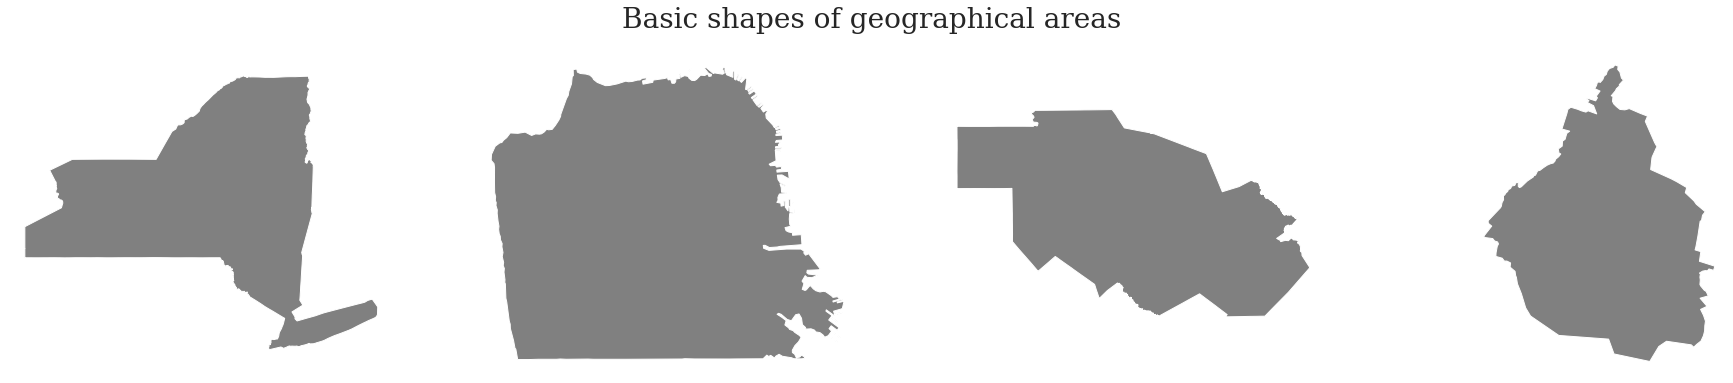

In [19]:
background_color = 'gray'
tess_color = "tab20b"

fig, ax = plt.subplots(1,4, figsize=(32, 6)) 
fig.suptitle('Basic shapes of geographical areas', fontsize = 28)
np.vectorize(lambda ax:ax.axis('off'))(ax)

area1_merged.plot(ax = ax[0], color = background_color)
area2_merged.plot(ax = ax[1], color = background_color)
area3_merged.plot(ax = ax[2], color = background_color)
area4_merged.plot(ax = ax[3], color = background_color)

/usr/local/lib/python3.8/dist-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/usr/local/lib/python3.8/dist-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


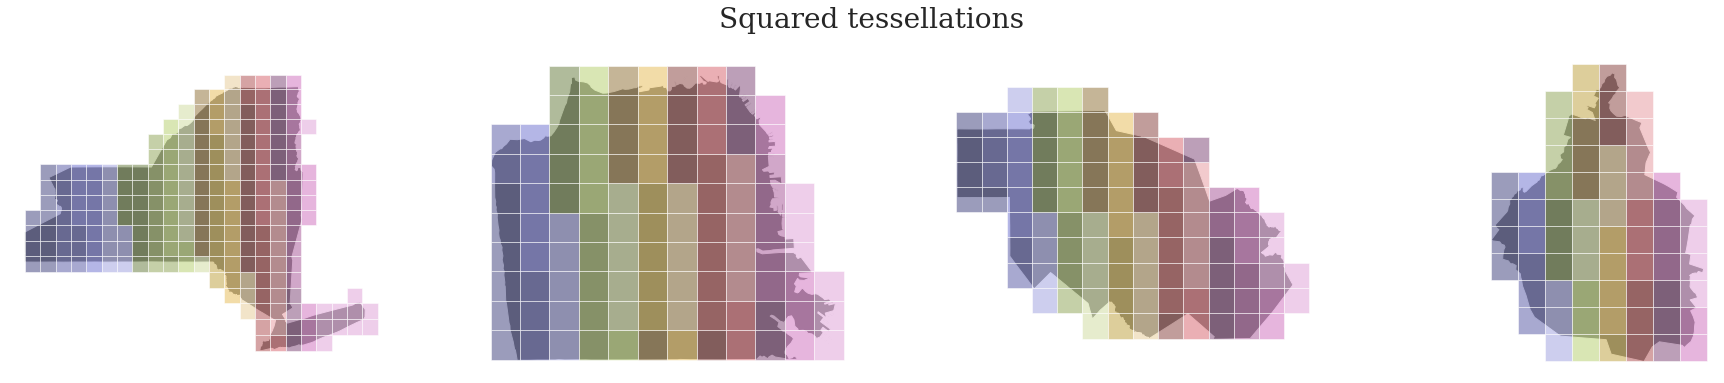

In [20]:
fig, ax = plt.subplots(1,4, figsize=(32, 6)) 
fig.suptitle('Squared tessellations', fontsize = 28)
np.vectorize(lambda ax:ax.axis('off'))(ax)

area1_merged.plot(ax = ax[0], color = background_color)
area2_merged.plot(ax = ax[1], color = background_color)
area3_merged.plot(ax = ax[2], color = background_color)
area4_merged.plot(ax = ax[3], color = background_color)

dict_tessellations['a1_t1'].plot(ax = ax[0], cmap = tess_color, alpha = .5)
dict_tessellations['a2_t1'].plot(ax = ax[1], cmap = tess_color, alpha = .5)
dict_tessellations['a3_t1'].plot(ax = ax[2], cmap = tess_color, alpha = .5)
dict_tessellations['a4_t1'].plot(ax = ax[3], cmap = tess_color, alpha = .5)

/usr/local/lib/python3.8/dist-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/usr/local/lib/python3.8/dist-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


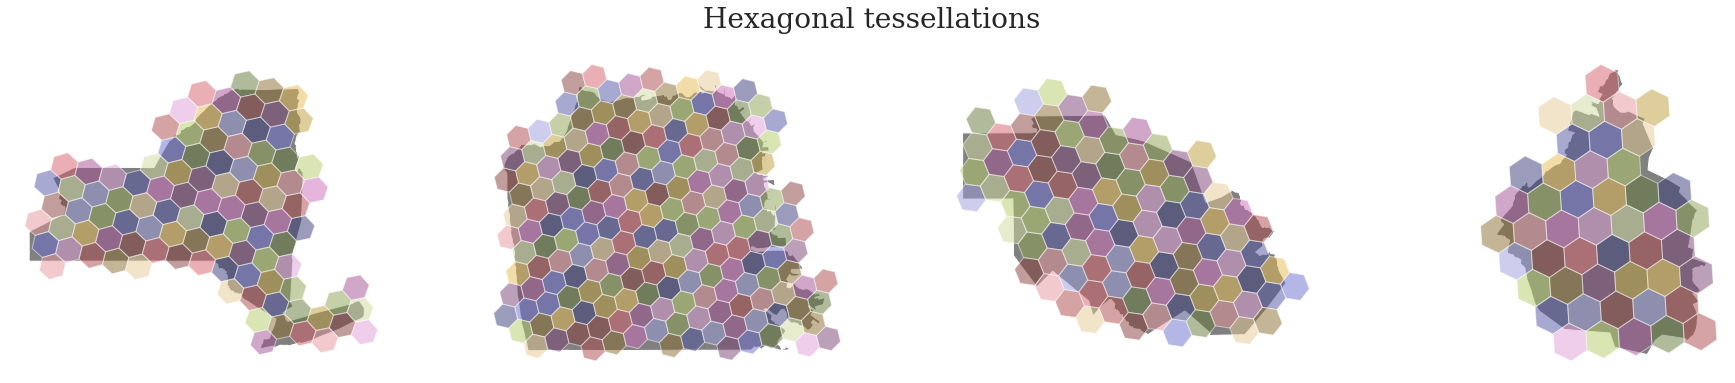

In [21]:
fig, ax = plt.subplots(1,4, figsize=(32, 6)) 
fig.suptitle('Hexagonal tessellations', fontsize = 28)
np.vectorize(lambda ax:ax.axis('off'))(ax)

area1_merged.plot(ax = ax[0], color = background_color)
area2_merged.plot(ax = ax[1], color = background_color)
area3_merged.plot(ax = ax[2], color = background_color)
area4_merged.plot(ax = ax[3], color = background_color)

dict_tessellations['a1_t2'].plot(ax = ax[0], cmap = tess_color, alpha = .5)
dict_tessellations['a2_t2'].plot(ax = ax[1], cmap = tess_color, alpha = .5)
dict_tessellations['a3_t2'].plot(ax = ax[2], cmap = tess_color, alpha = .5)
dict_tessellations['a4_t2'].plot(ax = ax[3], cmap = tess_color, alpha = .5)

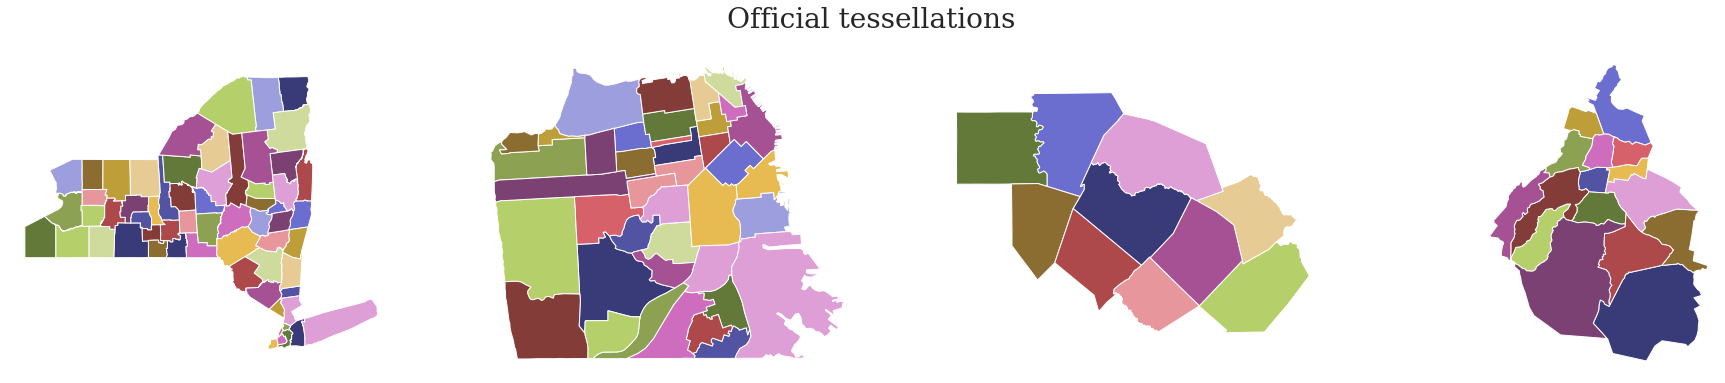

In [22]:
fig, ax = plt.subplots(1,4, figsize=(32, 6)) 
fig.suptitle('Official tessellations', fontsize = 28)
np.vectorize(lambda ax:ax.axis('off'))(ax)

dict_tessellations['a1_t3'].plot(ax = ax[0], cmap = tess_color)
dict_tessellations['a2_t3'].plot(ax = ax[1], cmap = tess_color)
dict_tessellations['a3_t3'].plot(ax = ax[2], cmap = tess_color)
dict_tessellations['a4_t3'].plot(ax = ax[3], cmap = tess_color)

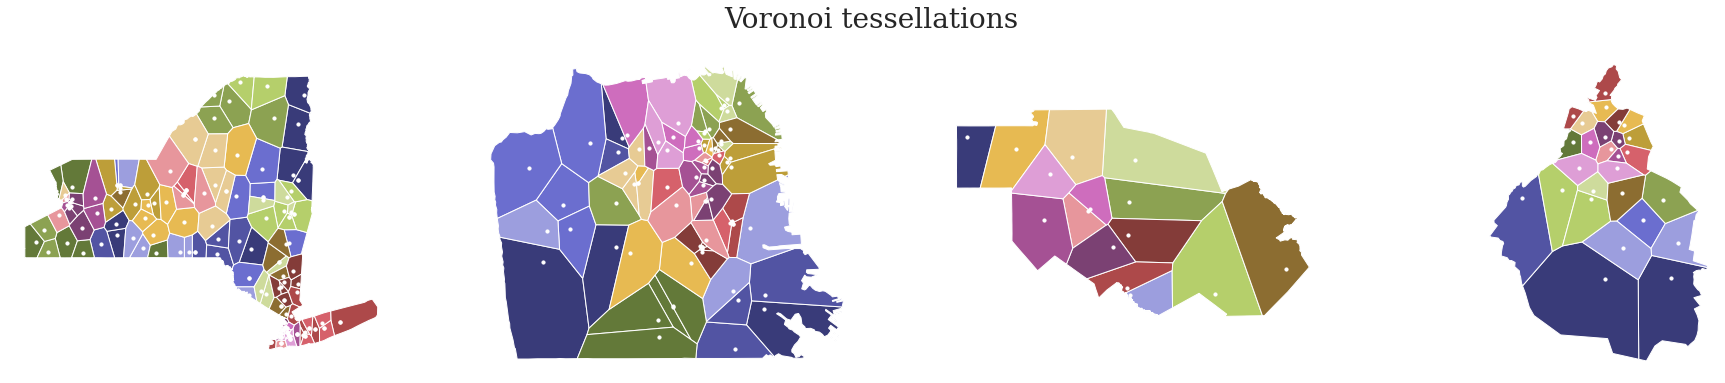

In [23]:
fig, ax = plt.subplots(1,4, figsize=(32, 6)) 
fig.suptitle('Voronoi tessellations', fontsize = 28)
np.vectorize(lambda ax:ax.axis('off'))(ax)

vor_point_color = 'white'
markersize = 10

dict_tessellations['a1_t4'].plot(ax = ax[0], cmap = tess_color)
dict_tessellations['a2_t4'].plot(ax = ax[1], cmap = tess_color)
dict_tessellations['a3_t4'].plot(ax = ax[2], cmap = tess_color)
dict_tessellations['a4_t4'].plot(ax = ax[3], cmap = tess_color)

points1_gdf.plot(ax = ax[0], color = vor_point_color, markersize = markersize)
points2_gdf.plot(ax = ax[1], color = vor_point_color, markersize = markersize)
points3_gdf.plot(ax = ax[2], color = vor_point_color, markersize = markersize)
points4_gdf.plot(ax = ax[3], color = vor_point_color, markersize = markersize)

Creating TDFs for each area

Using the following mobility traces datasets:

1. Brightkite check-ins
2. San Francisco Taxicab traces
3. Gowalla check-ins
4. Mexico City Taxicab traces

In [24]:
# Creating trajectory dataframe for Area 1 - New York State
# Trajectories obtained from brightkite checkins dataset
url = "https://snap.stanford.edu/data/loc-brightkite_totalCheckins.txt.gz"
area1_df = pd.read_csv(url, sep='\t', header=0, nrows = 1000000, names=['user', 'check-in_time', "latitude", "longitude", "location id"])
area1_tdf = skmob.TrajDataFrame(area1_df, latitude='latitude', longitude='longitude', datetime='check-in_time', user_id='user')
print("Users: ", len(area1_tdf.uid.unique()))
print('Records: ', len(area1_tdf)) 
area1_tdf.head()

Users:  2757
Records:  1000000


uid                  datetime        lat         lng  \
0    0 2010-10-16 06:02:04+00:00  39.891383 -105.070814   
1    0 2010-10-16 03:48:54+00:00  39.891077 -105.068532   
2    0 2010-10-14 18:25:51+00:00  39.750469 -104.999073   
3    0 2010-10-14 00:21:47+00:00  39.752713 -104.996337   
4    0 2010-10-13 23:31:51+00:00  39.752508 -104.996637   

                                location id  
0          7a0f88982aa015062b95e3b4843f9ca2  
1          dd7cd3d264c2d063832db506fba8bf79  
2  9848afcc62e500a01cf6fbf24b797732f8963683  
3          2ef143e12038c870038df53e0478cefc  
4          424eb3dd143292f9e013efa00486c907

In [25]:
# Visualizing trajectories flowing through Area 1
map_f = folium.Map(location=[42.631610, -73.935242], zoom_start=7, tiles='cartodbdark_matter')

# Outlining official tessellation
for _, row in dict_tessellations['a1_t3'].iterrows():
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function = lambda x: {'fillColor': '#98ff69', 'color': 'white'})
    geo_j.add_to(map_f)
    
area1_tdf.plot_trajectory(map_f = map_f, max_users = 20, weight = 1, max_points = None, opacity=0.9, start_end_markers = False)

In [26]:
# Creating trajectory dataframe for Area 2 -  San Francisco
# Trajectories obtained from taxicab dataset, retrieved from Crawdad repository (http://crawdad.org/epfl/mobility/20090224/index.html), using a sample of 6 taxis
url = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/new_abboip.txt'
url1 = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/new_effneomi.txt'
url2 = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/new_iawxben.txt'
url3 = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/new_ofikco.txt'
url4 = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/new_udwadla.txt'
url5 = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/new_upthin.txt'
list_url = [url, url1, url2, url3, url4, url5]

dataframes = []
for i, url in enumerate(list_url):
    df = pd.read_csv(url, sep=' ', names=['lat', 'lng', "occupancy", "datetime"])
    df['datetime'] = pd.to_datetime(df['datetime'], unit='s')
    df['uid'] = i+1
    dataframes.append(df)

area2_df = pd.concat(dataframes)
area2_tdf = skmob.TrajDataFrame(area2_df, latitude='lat', longitude='lng', datetime='datetime', user_id='uid')
print("Users: ", len(area2_tdf.uid.unique()))
print('Records: ', len(area2_tdf))
area2_tdf.head()

Users:  6
Records:  189919


lat        lng  occupancy            datetime  uid
0  37.75134 -122.39488          0 2008-06-10 07:58:07    1
1  37.75136 -122.39527          0 2008-06-10 07:57:39    1
2  37.75199 -122.39460          0 2008-06-10 07:55:40    1
3  37.75080 -122.39346          0 2008-06-10 07:54:49    1
4  37.75015 -122.39256          0 2008-06-10 07:50:37    1

In [27]:
# Visualizing trajectories flowing through Area 2
map_f = folium.Map(location=[37.75134, -122.39488], zoom_start=12, tiles='cartodbdark_matter')

# Outlining official tessellation and adding name of neighborghoods as folium popup
for _, row in dict_tessellations['a2_t3'].iterrows():
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function = lambda x: {'fillColor': '#98ff69', 'color': 'white'})
    folium.Popup(row['nhood']).add_to(geo_j)
    geo_j.add_to(map_f)
    
area2_tdf.plot_trajectory(map_f = map_f, hex_color = '#59fff7', max_users = 1, zoom = 12, weight = 1, max_points = 200, opacity=0.9, start_end_markers = False)

/usr/local/lib/python3.8/dist-packages/skmob/core/trajectorydataframe.py:569: UserWarning: If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.
  return plot.plot_trajectory(self, map_f=map_f, max_users=max_users, max_points=max_points, style_function=style_function,


In [28]:
# Creating trajectory dataframe for Area 3 - Austin
# Trajectories obtained from Gowalla checkins dataset
url = "https://snap.stanford.edu/data/loc-gowalla_totalCheckins.txt.gz"
area3_df = pd.read_csv(url, sep='\t', header=0, nrows = 1000000, names=['user', 'check-in_time', "latitude", "longitude", "location id"])
area3_tdf = skmob.TrajDataFrame(area3_df, latitude='latitude', longitude='longitude', datetime='check-in_time', user_id='user')
print("Users: ", len(area3_tdf.uid.unique()))
print('Records: ', len(area3_tdf))
area3_tdf.head()

Users:  3979
Records:  1000000


uid                  datetime        lat        lng  location id
0    0 2010-10-18 22:17:43+00:00  30.269103 -97.749395       420315
1    0 2010-10-17 23:42:03+00:00  30.255731 -97.763386       316637
2    0 2010-10-17 19:26:05+00:00  30.263418 -97.757597        16516
3    0 2010-10-16 18:50:42+00:00  30.274292 -97.740523      5535878
4    0 2010-10-12 23:58:03+00:00  30.261599 -97.758581        15372

In [29]:
# Visualizing trajectories flowing through Area 3
map_f = folium.Map(location=[30.266666, -97.733330], zoom_start=8, tiles='cartodbdark_matter')

# Outlining official tessellation and adding name of counties as folium popup
for _, row in dict_tessellations['a3_t3'].iterrows():
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function = lambda x: {'fillColor': '#98ff69', 'color': 'white'})
    folium.Popup(row['county_name']).add_to(geo_j)
    geo_j.add_to(map_f)
    
area3_tdf.plot_trajectory(map_f = map_f, max_users = 50, weight = 1, max_points = None, opacity=0.9, start_end_markers = False)

In [30]:
# Creating trajectory dataframe for Area 4 - Mexico City
# Trajectories obtained from Kaggle Taxi traces dataset. (https://www.kaggle.com/datasets/mnavas/taxi-routes-for-mexico-city-and-quito?select=mex_clean.csv)
url = 'https://raw.githubusercontent.com/Bruno-Limon/EPR-model-comparison/main/Data/mex_clean.csv'
area4_df = pd.read_csv(url)
mapping = {item:i for i, item in enumerate(area4_df["vendor_id"].unique())}
area4_df["uid"] = area4_df["vendor_id"].apply(lambda x: mapping[x])
area4_df.drop(['vendor_id', 'id', 'dropoff_datetime', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'dist_meters', 'wait_sec'], axis=1, inplace=True)

area4_tdf = skmob.TrajDataFrame(area4_df, latitude='pickup_latitude', longitude='pickup_longitude', datetime='pickup_datetime', user_id='uid')
print("Users: ", len(area4_tdf.uid.unique()))
print('Records: ', len(area4_tdf))
area4_tdf.head()

Users:  7
Records:  12694


datetime        lng        lat  uid
0 2016-09-16 07:14:12 -99.097369  19.416874    0
1 2016-09-18 06:16:33 -99.297148  19.322128    1
2 2016-09-18 10:11:50 -99.289603  19.326263    1
3 2016-09-18 10:23:38 -99.271161  19.328875    1
4 2016-09-18 10:44:18 -99.282761  19.326944    1

In [31]:
# Visualizing trajectories flowing through Area 4
map_f = folium.Map(location=[19.2016874, -99.097369], zoom_start=10, tiles='cartodbdark_matter')

# Outlining official tessellation and adding name of neighborghoods as folium popup
for _, row in dict_tessellations['a4_t3'].iterrows():
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function = lambda x: {'fillColor': '#98ff69', 'color': 'white'})
    folium.Popup(row['nomgeo']).add_to(geo_j)
    geo_j.add_to(map_f)
    
area4_tdf.plot_trajectory(map_f = map_f, max_users = 1, hex_color = '#59fff7', weight = 1, max_points = 200, opacity = 0.9, start_end_markers = False)

/usr/local/lib/python3.8/dist-packages/skmob/core/trajectorydataframe.py:569: UserWarning: If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.
  return plot.plot_trajectory(self, map_f=map_f, max_users=max_users, max_points=max_points, style_function=style_function,


TDFS for the real traces dataframes

In [32]:
%%capture
list_areas_tdfs = [area1_tdf, area2_tdf, area3_tdf, area4_tdf]
list_tessellations = ['squared', 'hexagonal', 'official', 'voronoi']
dict_real_tdfs = {}
dict_weighted_tess = {}

for i in range(1, len(list_areas_tdfs)+1):
    for j in range(1, len(list_tessellations)+1):
        # Mapping area traces with tessellation
        dict_real_tdfs['a{}_t{}'.format(i,j)] = list_areas_tdfs[i-1].mapping(dict_tessellations['a{}_t{}'.format(i,j)], remove_na=True)
        
        # Counting visits per tile to use as parameter for weighted tessellation
        visits_per_tile = dict_real_tdfs['a{}_t{}'.format(i,j)].groupby("tile_ID", as_index=False).count()
        visits_per_tile = visits_per_tile[["tile_ID", "uid"]]
        visits_per_tile["relevance"] = visits_per_tile["uid"]
        visits_per_tile = visits_per_tile[["tile_ID", "relevance"]]

        dict_weighted_tess['a{}_t{}'.format(i,j)] = dict_tessellations['a{}_t{}'.format(i,j)].set_index("tile_ID").join(visits_per_tile.set_index("tile_ID"))
        dict_weighted_tess['a{}_t{}'.format(i,j)] = dict_weighted_tess['a{}_t{}'.format(i,j)].fillna(0)
        dict_weighted_tess['a{}_t{}'.format(i,j)] = dict_weighted_tess['a{}_t{}'.format(i,j)][dict_weighted_tess['a{}_t{}'.format(i,j)]["relevance"]>0]

In [33]:
# Creating a dictionary to map area_tessellation pairs with their names
dict_area_tess_names = {}
area_names = ['New York State', 'San Francisco', 'Houston', 'Mexico City']

for i, area in enumerate(area_names, start = 1):
    for j, tess in enumerate(list_tessellations, start = 1):
        dict_area_tess_names['a{}_t{}'.format(i,j)] = str(area + ' - ' + tess + ' tessellation')

In [35]:
# Calculating measures for the real TDFs
dict_real_measures = {}
show_df = True

for i in range(1, len(list_areas_tdfs)+1):
    for j in range(1, len(list_tessellations)+1):
        if show_df == True: print('\na{}_t{} measures'.format(i,j))
        dict_real_measures['a{}_t{}'.format(i,j)] = compute_measures(dict_real_tdfs['a{}_t{}'.format(i,j)])


a1_t1 measures
           M1        M2      M3        M4         M5      M6
Min    1.0014    1.0202  0.1301    1.0000     1.0000  0.0005
Max  573.8451  280.7658  7.3308  300.0000  3626.0000  0.4895
Avg   18.4182   36.1628  2.7565   16.1893     4.8066  0.0070
Std   47.9898   54.8711  1.4577   36.7033    48.3486  0.0324

a1_t2 measures
           M1        M2      M3        M4         M5      M6
Min    1.0014    1.0202  0.1301    1.0000     1.0000  0.0005
Max  604.9552  227.4705  7.3411  301.0000  3626.0000  0.4862
Avg   17.9468   35.3658  2.7385   16.6457     4.8487  0.0069
Std   45.0640   52.3597  1.4658   37.5355    48.4629  0.0321

a1_t3 measures
           M1        M2      M3        M4         M5      M6
Min    1.0035    1.0151  0.0655    1.0000     1.0000  0.0005
Max  498.5521  241.4709  7.2493  276.0000  3626.0000  0.4895
Avg   16.7516   30.0029  2.7066   14.6349     4.3823  0.0079
Std   46.5685   49.3197  1.4719   32.2474    50.1335  0.0338

a1_t4 measures
           M1        

# **<font color="#ffb94f">2.0 BUILDING MODELS & COMPARING DISTRIBUTIONS</font>**

The comparison among distributions is made on an area_tessellation basis, computing 6 measures of model realism, they are as follows:

1. Travel Distance
2. Radius of Gyration
3. Uncorrelated Entropy
4. Distinct Visited Locations
5. Visits per Location
6. Location Frequency

Then, the distribution for each of these measures across all models is plotted, together with the RMSE of their pairs

In [57]:
# Denoting if the real TDF is taken into account into the comparison plot
show_real = False

# Parameters to use in EPR models
number_agents = 5000
number_individuals = 5000 # Used for Ditras Markov Diaries Generator
start_time = pd.to_datetime('2023/01/01 00:00:00')
end_time = pd.to_datetime('2023/01/15 00:00:00')

## **<font color="#84f745">2.1 AREA 1 - NEW YORK STATE</font>**

### **<font color="#4fffd9">2.1.1 AREA 1 - TESSELLATION 1</font>**

Building S-EPR model for New York State - squared tessellation


100%|██████████| 5000/5000 [06:58<00:00, 11.94it/s]



S-EPR measures:
           M1        M2      M3       M4         M5      M6
Min   28.2087   55.5828  3.7995  27.0000   486.0000  0.0035
Max  687.8895  283.9377  5.5776  74.0000  6409.0000  0.1374
Avg  140.2532  136.9539  4.7832  50.0996  5210.5782  0.0148
Std  110.7076   29.7085  0.2608   7.0120   866.4717  0.0231

Building D-EPR model for New York State - squared tessellation


100%|██████████| 5000/5000 [06:34<00:00, 12.66it/s]



D-EPR measures:
           M1        M2      M3       M4           M5      M6
Min   28.5218   20.7385  1.9321   5.0000     643.0000  0.0039
Max  661.3300  261.6108  3.9887  26.0000  268101.0000  0.2700
Avg  118.8131  124.4493  2.8587  12.8510    8723.7937  0.0412
Std  141.8299   68.8164  0.3811   3.5617   33371.2928  0.0690

Building Ditras model for New York State - squared tessellation


100%|██████████| 5000/5000 [00:59<00:00, 84.43it/s]



Ditras measures:
           M1        M2      M3      M4         M5      M6
Min   28.5218   12.3775  0.8113  1.0000    89.0000  0.0345
Max  623.1215  304.0725  2.9313  9.0000  5599.0000  0.5837
Avg  161.1885   96.7602  1.3523  2.8180   350.2698  0.1587
Std  135.7083   64.5038  0.3807  1.1406   655.9323  0.1734

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



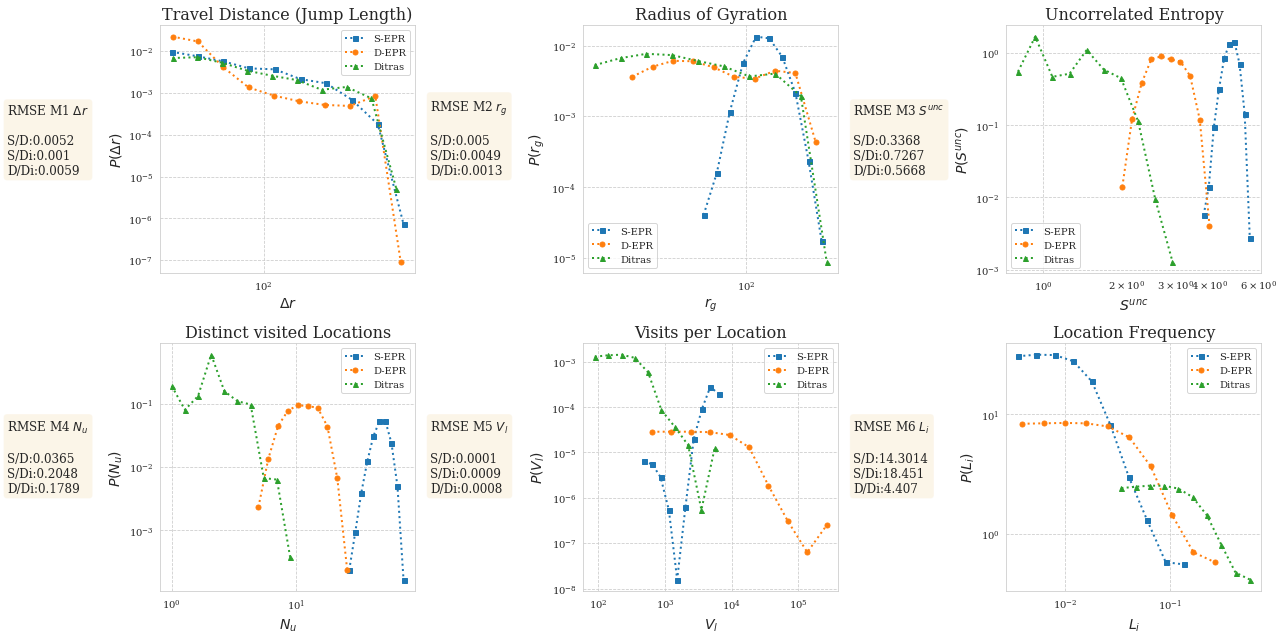

In [58]:
plot_comparison(area_tessellation = 'a1_t1', n_agents = number_agents, show_real = show_real)

### **<font color="#4fffd9">2.1.2 AREA 1 - TESSELLATION 2</font>**

Building S-EPR model for New York State - hexagonal tessellation


100%|██████████| 5000/5000 [06:42<00:00, 12.42it/s]



S-EPR measures:
           M1        M2      M3       M4          M5      M6
Min   43.9854   74.1153  3.4572  22.0000    843.0000  0.0037
Max  685.6175  271.1258  5.3409  64.0000  14643.0000  0.1418
Avg  158.1997  148.7333  4.5951  42.7756  10979.4000  0.0170
Std  113.2713   27.5744  0.2559   5.8155   2233.8546  0.0256

Building D-EPR model for New York State - hexagonal tessellation


100%|██████████| 5000/5000 [06:28<00:00, 12.86it/s]



D-EPR measures:
           M1        M2      M3       M4           M5      M6
Min   43.9854   26.1487  1.5267   4.0000    1234.0000  0.0043
Max  659.0164  250.8096  3.6465  20.0000  319900.0000  0.3035
Avg  132.8410  126.4804  2.5830  10.9500   14682.0133  0.0526
Std  135.4252   61.3559  0.3686   2.8027   50486.2765  0.0858

Building Ditras model for New York State - hexagonal tessellation


100%|██████████| 5000/5000 [01:00<00:00, 82.12it/s]



Ditras measures:
           M1        M2      M3      M4         M5      M6
Min   43.9854   19.0801  0.8113  1.0000   239.0000  0.0476
Max  632.5091  283.9640  2.7559  8.0000  6712.0000  0.5883
Avg  179.7204  104.9916  1.3245  2.7282   585.5600  0.1758
Std  133.8436   62.6829  0.3680  1.0751   989.7053  0.1796

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



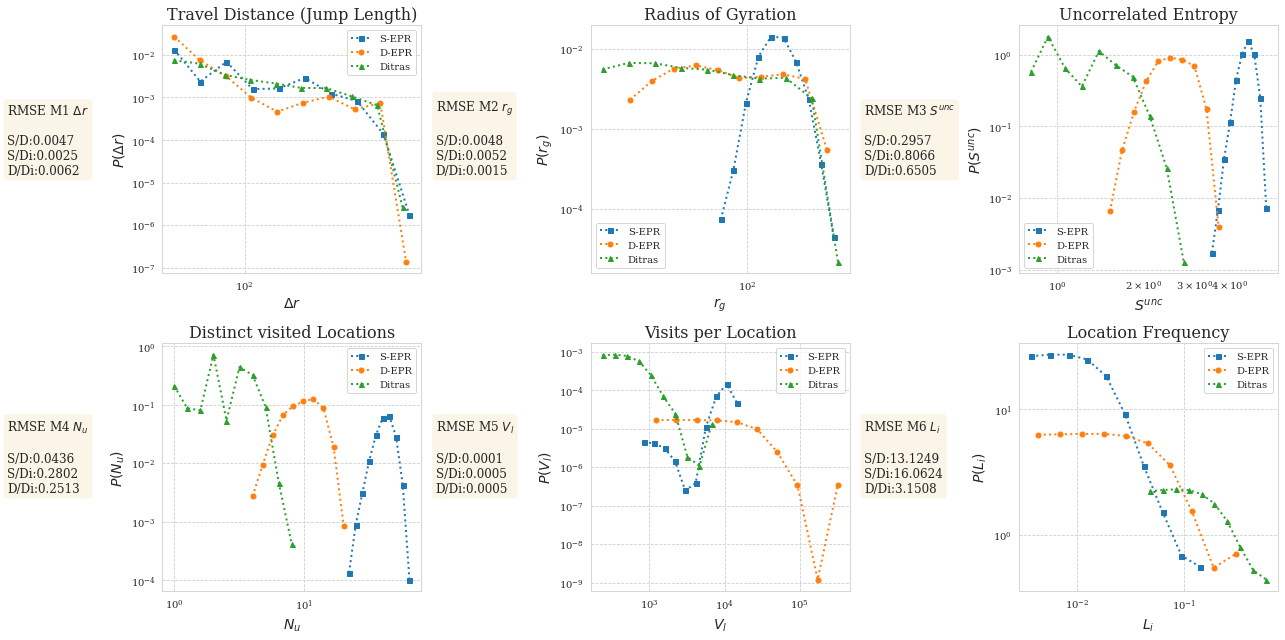

In [59]:
plot_comparison(area_tessellation = 'a1_t2', n_agents = number_agents, show_real = show_real)

### **<font color="#4fffd9">2.1.3 AREA 1 - TESSELLATION 3</font>**

Building S-EPR model for New York State - official tessellation


100%|██████████| 5000/5000 [06:33<00:00, 12.70it/s]



S-EPR measures:
           M1        M2      M3       M4          M5      M6
Min    1.1886    1.0419  1.0000   2.0000   1609.0000  0.0033
Max  578.6253  219.8983  5.1001  52.0000  71855.0000  0.1736
Avg  117.3786  115.4998  4.0630  31.3302  17161.8125  0.0213
Std  102.9984   40.0304  0.7294   9.1986  10831.1534  0.0338

Building D-EPR model for New York State - official tessellation


100%|██████████| 5000/5000 [06:28<00:00, 12.86it/s]



D-EPR measures:
           M1        M2      M3       M4           M5      M6
Min    9.7700    8.9490  1.5354   4.0000    1437.0000  0.0038
Max  578.6253  234.4197  3.6745  21.0000  342629.0000  0.3137
Avg  106.6990  111.9571  2.5708  10.3492   19006.3621  0.0507
Std  139.5228   65.4868  0.3838   2.9463   57182.4309  0.0839

Building Ditras model for New York State - official tessellation


100%|██████████| 5000/5000 [00:57<00:00, 87.29it/s]



Ditras measures:
           M1        M2      M3      M4         M5      M6
Min    9.7700    4.3844  0.8113  1.0000   237.0000  0.0555
Max  543.6053  251.1028  2.6635  7.0000  7402.0000  0.6290
Avg  165.2246   96.8404  1.3030  2.5176   642.6379  0.2027
Std  136.8928   63.8920  0.3754  1.1177  1031.1144  0.1962

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



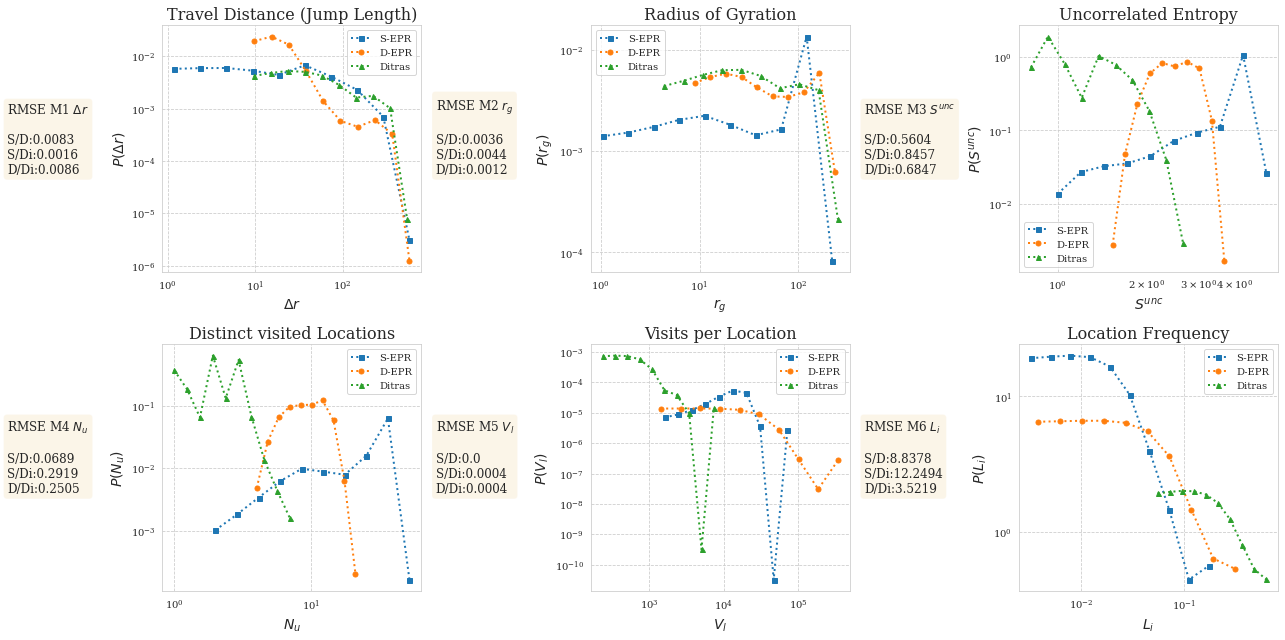

In [60]:
plot_comparison(area_tessellation = 'a1_t3', n_agents = number_agents, show_real = show_real)

### **<font color="#4fffd9">2.1.4 AREA 1 - TESSELLATION 4</font>**

Building S-EPR model for New York State - voronoi tessellation


100%|██████████| 5000/5000 [07:00<00:00, 11.90it/s]



S-EPR measures:
           M1        M2      M3       M4          M5      M6
Min    3.1311    6.4412  3.0249  14.0000    824.0000  0.0039
Max  616.4635  238.5445  5.3153  64.0000  25069.0000  0.1506
Avg  102.3050  107.9678  4.3742  37.4656   8870.1452  0.0174
Std  108.8291   49.5844  0.3899   9.1380   4363.1294  0.0277

Building D-EPR model for New York State - voronoi tessellation


100%|██████████| 5000/5000 [06:36<00:00, 12.62it/s]



D-EPR measures:
           M1        M2      M3       M4           M5      M6
Min    3.1311    3.0382  1.3794   5.0000     627.0000  0.0042
Max  616.4635  245.5929  4.0638  27.0000  233686.0000  0.2684
Avg   76.0419   94.3589  2.8880  13.3048    9921.7748  0.0399
Std  130.3961   72.6672  0.4221   3.9783   31439.0476  0.0670

Building Ditras model for New York State - voronoi tessellation


100%|██████████| 5000/5000 [00:59<00:00, 84.40it/s]



Ditras measures:
           M1        M2      M3      M4         M5      M6
Min    3.1311    1.3558  0.8113  1.0000   113.0000  0.0401
Max  544.7010  265.5935  2.6464  8.0000  4016.0000  0.6273
Avg  114.5902   69.4122  1.3291  2.5956   337.5856  0.1807
Std  127.2965   63.6801  0.3924  1.1980   511.7768  0.1903

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



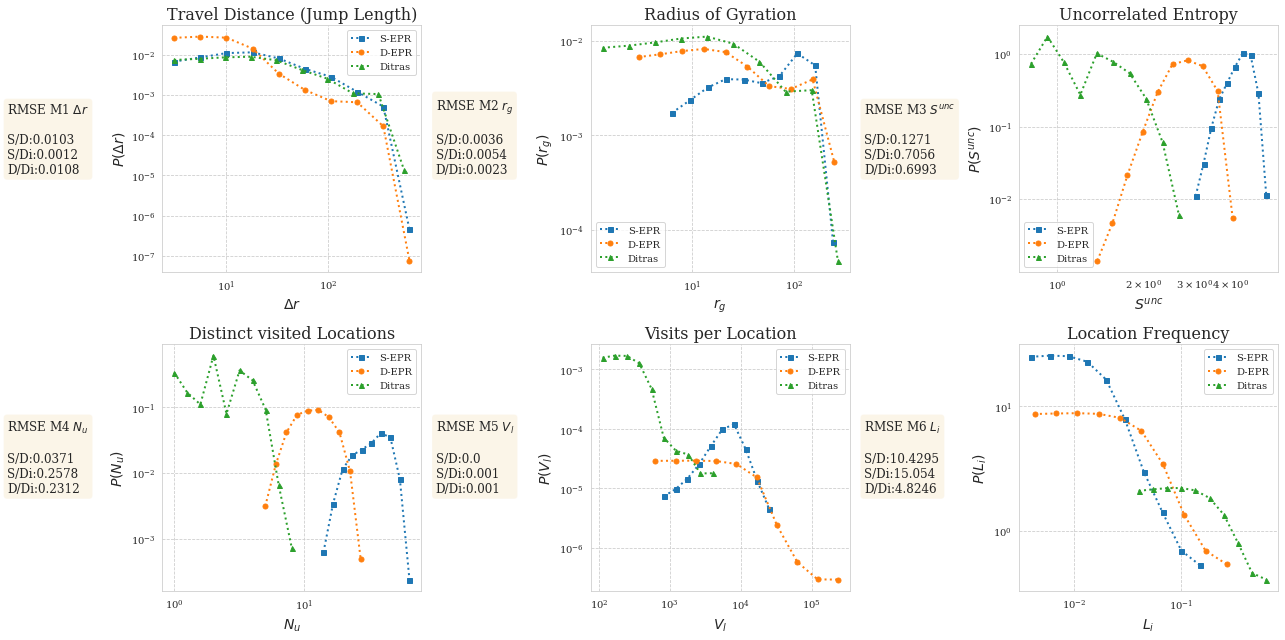

In [61]:
plot_comparison(area_tessellation = 'a1_t4', n_agents = number_agents, show_real = show_real)

## **<font color="#84f745">2.2 AREA 2 - SAN FRANCISCO</font>**

### **<font color="#4fffd9">2.2.1 AREA 2 - TESSELLATION 1</font>**

Building S-EPR model for San Francisco - squared tessellation


100%|██████████| 5000/5000 [06:12<00:00, 13.41it/s]



S-EPR measures:
          M1      M2      M3       M4          M5      M6
Min   1.1838  2.2386  3.6613  22.0000    912.0000  0.0037
Max  15.4465  5.9983  5.4412  65.0000  13206.0000  0.1403
Avg   4.1782  3.8071  4.6476  44.4592  10558.5288  0.0167
Std   2.7311  0.5596  0.2460   5.6754   1981.1739  0.0251

Building D-EPR model for San Francisco - squared tessellation


100%|██████████| 5000/5000 [06:13<00:00, 13.38it/s]



D-EPR measures:
          M1      M2      M3       M4           M5      M6
Min   1.1838  1.2661  2.7617  11.0000     862.0000  0.0035
Max  13.8168  4.7851  4.8430  44.0000  149351.0000  0.1694
Avg   3.0895  2.6629  3.9089  25.3818   11223.1429  0.0245
Std   2.1129  0.6606  0.2772   4.1349   21777.0558  0.0371

Building Ditras model for San Francisco - squared tessellation


100%|██████████| 5000/5000 [01:35<00:00, 52.30it/s]



Ditras measures:
          M1      M2      M3       M4          M5      M6
Min   1.1838  1.0004  0.9834   2.0000   1134.0000  0.0152
Max  13.8168  6.1674  3.1612  18.0000  18770.0000  0.4604
Avg   4.0553  2.6897  2.1593   8.0990   2778.5306  0.0647
Std   2.6785  1.0743  0.3190   2.1031   2653.8660  0.1107

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



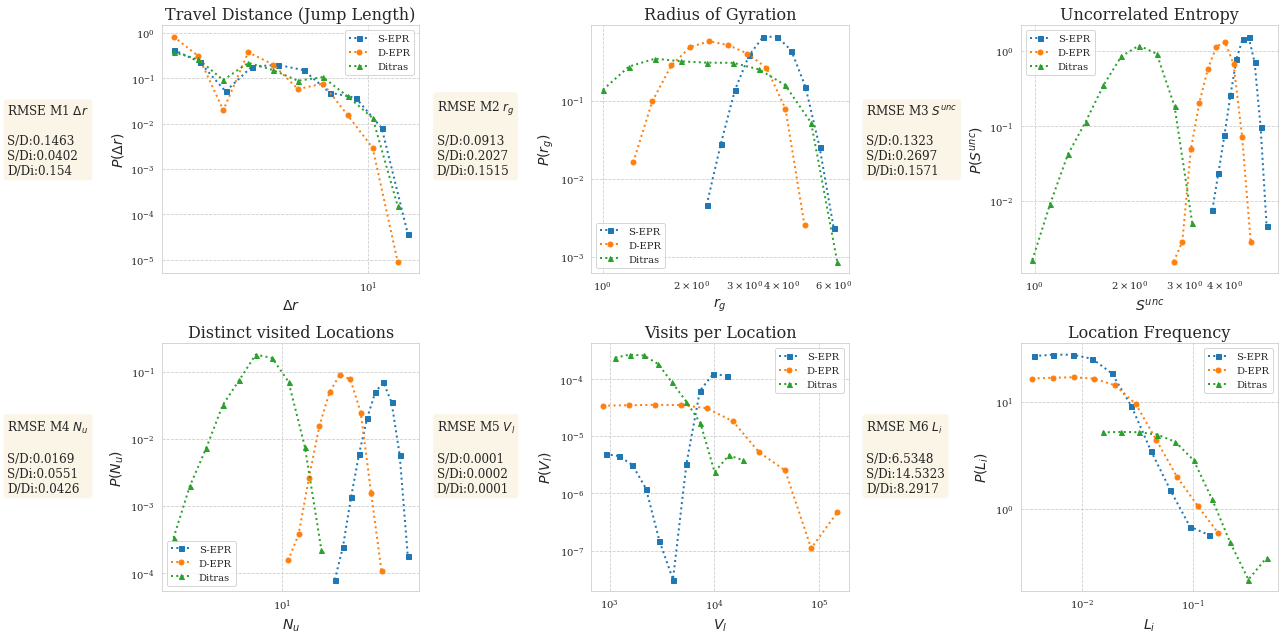

In [ ]:
plot_comparison(area_tessellation = 'a2_t1', n_agents = number_agents, show_real = show_real)

### **<font color="#4fffd9">2.2.2 AREA 2 - TESSELLATION 2</font>**

Building S-EPR model for San Francisco - hexagonal tessellation


100%|██████████| 5000/5000 [06:36<00:00, 12.60it/s]



S-EPR measures:
          M1      M2      M3       M4         M5      M6
Min   1.6066  2.0700  3.7205  26.0000   443.0000  0.0036
Max  15.9392  6.0591  5.6085  76.0000  7216.0000  0.1370
Avg   4.6995  3.7115  4.8006  50.6408  5770.1368  0.0145
Std   2.6319  0.6047  0.2523   6.7513   990.4024  0.0227

Building D-EPR model for San Francisco - hexagonal tessellation


100%|██████████| 5000/5000 [06:29<00:00, 12.85it/s]



D-EPR measures:
          M1      M2      M3       M4          M5      M6
Min   1.6066  1.0415  3.1209  17.0000    401.0000  0.0036
Max  13.8566  4.7692  5.0523  51.0000  94137.0000  0.1527
Avg   3.7603  2.6144  4.1922  31.6026   6508.2899  0.0212
Std   2.1504  0.7393  0.2952   5.3677  13385.6182  0.0316

Building Ditras model for San Francisco - hexagonal tessellation


100%|██████████| 5000/5000 [01:43<00:00, 48.42it/s]



Ditras measures:
          M1      M2      M3       M4          M5      M6
Min   1.6066  1.0001  1.1027   3.0000    367.0000  0.0147
Max  13.6455  6.3297  3.2682  17.0000  10843.0000  0.4602
Avg   4.7395  2.6933  2.1966   8.5452   1610.9763  0.0672
Std   2.6297  1.1161  0.3272   2.2076   1537.6983  0.1127

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



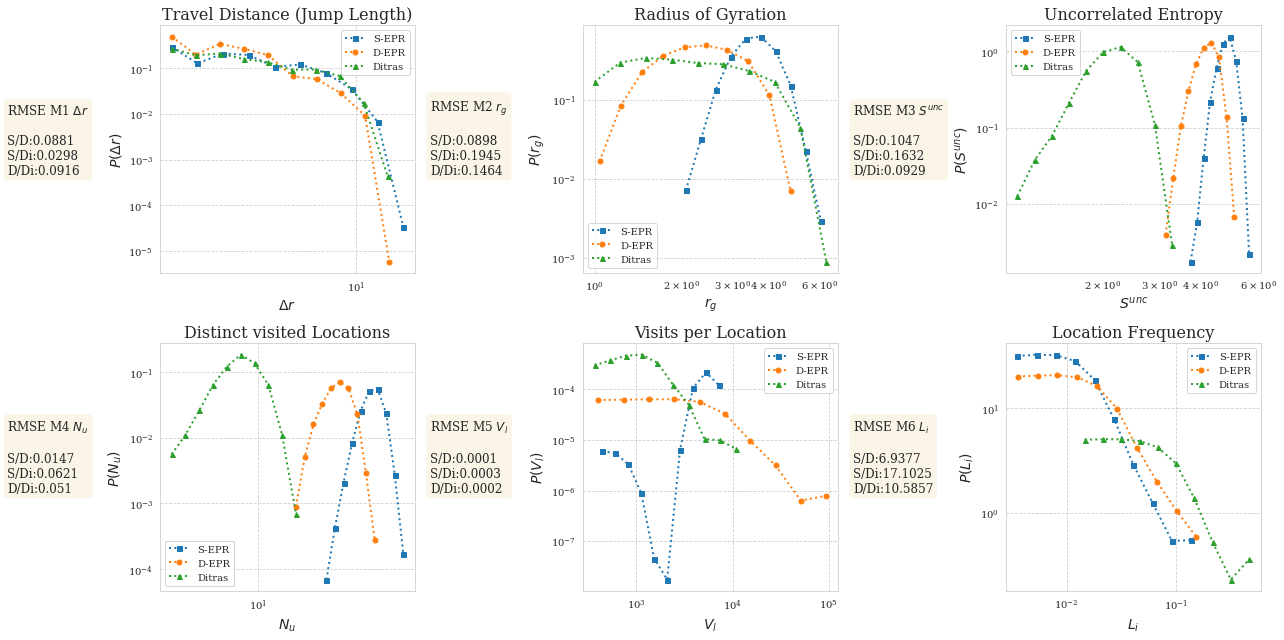

In [ ]:
plot_comparison(area_tessellation = 'a2_t2', n_agents = number_agents, show_real = show_real)

### **<font color="#4fffd9">2.2.3 AREA 2 - TESSELLATION 3</font>**

Building S-EPR model for San Francisco - official tessellation


100%|██████████| 5000/5000 [06:11<00:00, 13.47it/s]



S-EPR measures:
          M1      M2      M3       M4          M5      M6
Min   1.0112  1.4965  3.1170  15.0000   2371.0000  0.0041
Max  11.7614  4.7499  4.7625  39.0000  44469.0000  0.1552
Avg   3.7691  3.2431  4.1657  29.4004  26815.2927  0.0267
Std   2.2885  0.5389  0.2446   3.3627   8850.6382  0.0345

Building D-EPR model for San Francisco - official tessellation


100%|██████████| 5000/5000 [06:10<00:00, 13.50it/s]



D-EPR measures:
          M1      M2      M3       M4           M5      M6
Min   1.0112  1.1778  2.7122  10.0000    2437.0000  0.0043
Max  11.7614  4.7691  4.4679  30.0000  135788.0000  0.1734
Avg   3.1760  2.5723  3.6618  19.8090   27487.4750  0.0351
Std   2.0441  0.6851  0.2696   3.1222   33364.4852  0.0447

Building Ditras model for San Francisco - official tessellation


100%|██████████| 5000/5000 [01:38<00:00, 50.67it/s]



Ditras measures:
          M1      M2      M3       M4          M5      M6
Min   1.0112  1.0019  1.0994   3.0000   2941.0000  0.0149
Max  11.7614  5.5854  3.1392  15.0000  19946.0000  0.4636
Avg   3.7265  2.4760  2.0996   7.5558   6815.3750  0.0752
Std   2.3776  0.9773  0.3060   1.8685   4029.8162  0.1203

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



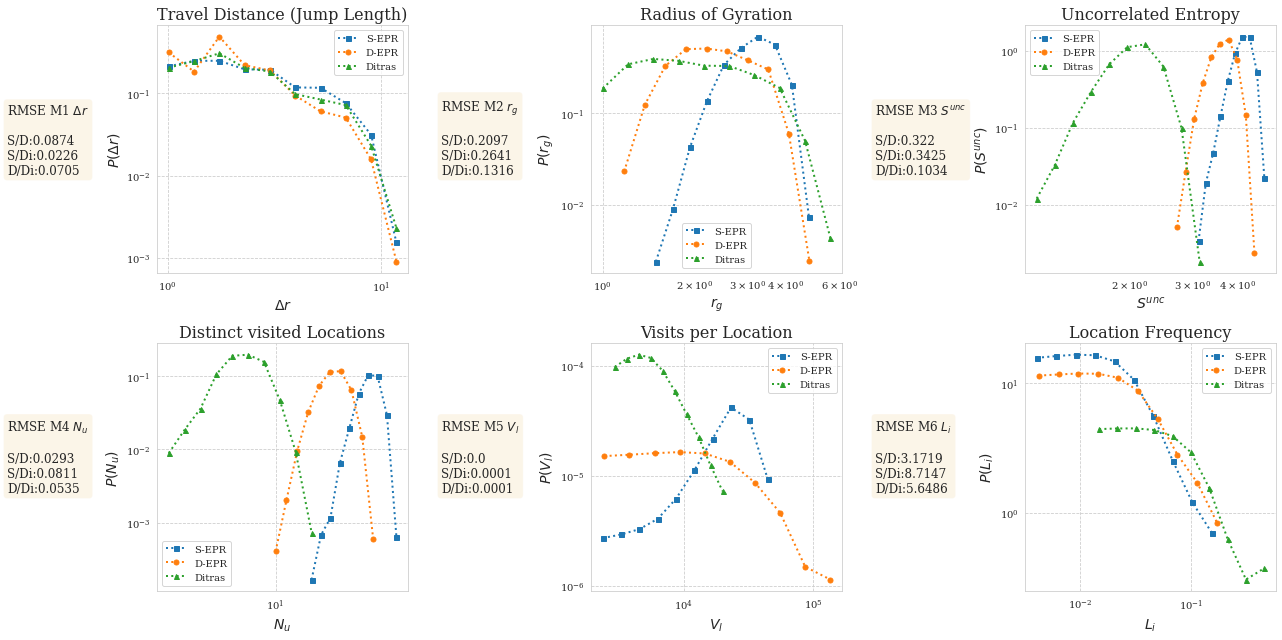

In [ ]:
plot_comparison(area_tessellation = 'a2_t3', n_agents = number_agents, show_real = show_real)

### **<font color="#4fffd9">2.2.4 AREA 2 - TESSELLATION 4</font>**

Building S-EPR model for San Francisco - voronoi tessellation


100%|██████████| 5000/5000 [06:23<00:00, 13.03it/s]



S-EPR measures:
          M1      M2      M3       M4          M5      M6
Min   1.0024  1.0000  2.8387  16.0000   1028.0000  0.0040
Max  12.0223  4.1236  5.2605  58.0000  36771.0000  0.1502
Avg   3.0517  2.1397  4.3739  36.4000  14075.8974  0.0188
Std   1.7566  0.6359  0.3104   5.7962   8226.6610  0.0286

Building D-EPR model for San Francisco - voronoi tessellation


100%|██████████| 5000/5000 [06:15<00:00, 13.31it/s]



D-EPR measures:
          M1      M2      M3       M4           M5      M6
Min   1.0024  1.0020  2.8406  16.0000    1315.0000  0.0039
Max  12.0223  4.2844  4.9041  47.0000  113600.0000  0.1572
Avg   2.9559  2.1044  4.1487  30.5046   14682.0133  0.0228
Std   1.7137  0.6281  0.2801   4.7190   18026.2802  0.0332

Building Ditras model for San Francisco - voronoi tessellation


100%|██████████| 5000/5000 [01:38<00:00, 51.01it/s]



Ditras measures:
          M1      M2      M3       M4          M5      M6
Min   1.0024  1.0000  0.9799   2.0000   1436.0000  0.0150
Max  11.1521  5.2713  3.2392  17.0000  15431.0000  0.4612
Avg   3.3088  2.0932  2.1629   8.2138   3618.0933  0.0675
Std   2.0710  0.8880  0.3239   2.1280   2226.1578  0.1134

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



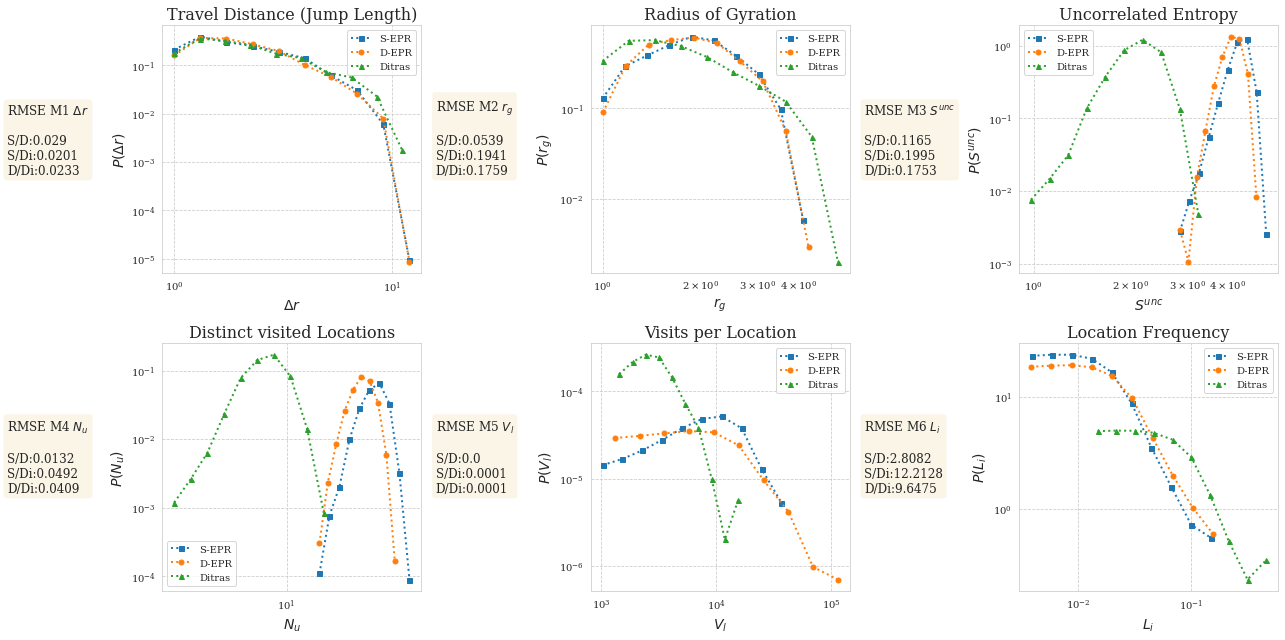

In [ ]:
plot_comparison(area_tessellation = 'a2_t4', n_agents = number_agents, show_real = show_real)

## **<font color="#84f745">2.3 AREA 3 - HOUSTON</font>**

### **<font color="#4fffd9">2.3.1 AREA 3 - TESSELLATION 1</font>**

Building S-EPR model for Houston - squared tessellation


100%|██████████| 5000/5000 [05:57<00:00, 13.97it/s]



S-EPR measures:
           M1       M2      M3       M4          M5      M6
Min   17.1061  28.9358  3.6936  24.0000   1012.0000  0.0032
Max  254.3899  98.2964  5.3272  65.0000  14162.0000  0.1419
Avg   59.8800  55.2811  4.6117  43.2310  11335.4948  0.0167
Std   40.6098   9.1592  0.2447   5.5449   2083.6168  0.0254

Building D-EPR model for Houston - squared tessellation


100%|██████████| 5000/5000 [05:53<00:00, 14.14it/s]



D-EPR measures:
           M1       M2      M3       M4           M5      M6
Min   17.1061  11.7784  1.7340   6.0000    1300.0000  0.0042
Max  201.0896  53.4933  3.0424  16.0000  409251.0000  0.3714
Avg   29.8198  23.7246  2.4420   9.1864   15518.9155  0.0647
Std   21.8964   7.4599  0.1725   1.3174   57136.1727  0.1001

Building Ditras model for Houston - squared tessellation


100%|██████████| 5000/5000 [01:08<00:00, 72.70it/s]



Ditras measures:
           M1       M2      M3      M4          M5      M6
Min   17.1337   7.4726  0.8113  1.0000    509.0000  0.0360
Max  201.5078  68.7338  2.6062  8.0000  35390.0000  0.4507
Avg   50.1707  30.3669  1.6200  3.8270   1577.8169  0.1487
Std   29.6203  12.5632  0.3094  1.0063   4364.1246  0.1506

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



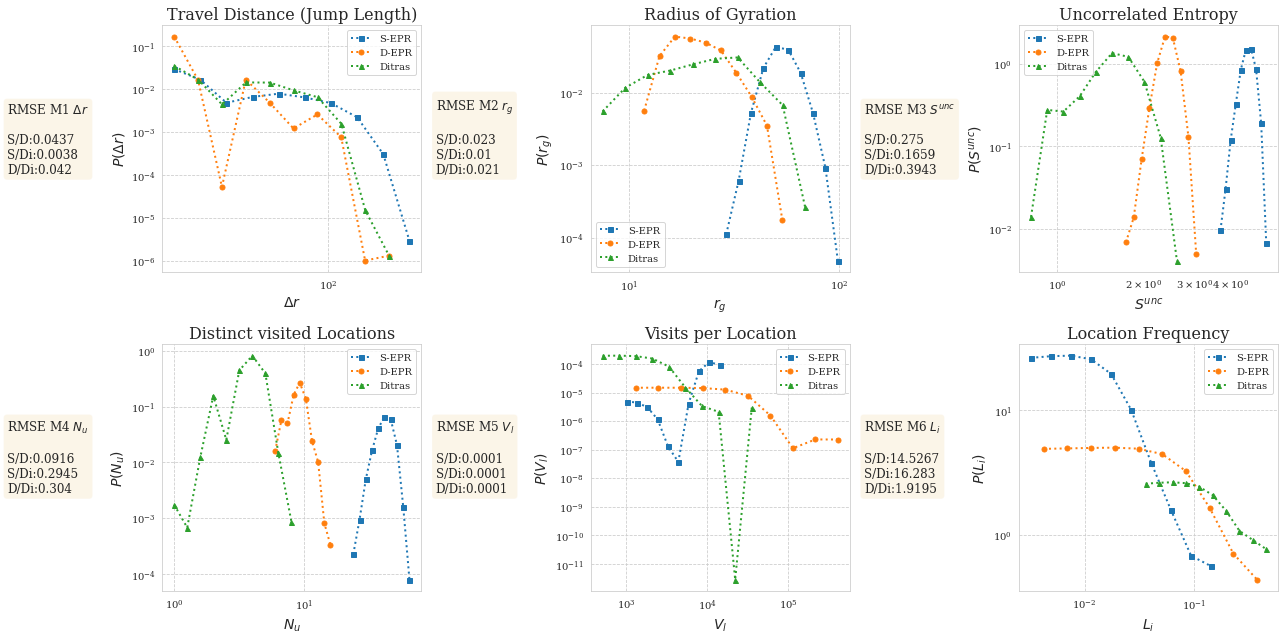

In [ ]:
plot_comparison(area_tessellation = 'a3_t1', n_agents = number_agents, show_real = show_real)

### **<font color="#4fffd9">2.3.2 AREA 3 - TESSELLATION 2</font>**

Building S-EPR model for Houston - hexagonal tessellation


100%|██████████| 5000/5000 [06:11<00:00, 13.47it/s]



S-EPR measures:
           M1        M2      M3       M4          M5      M6
Min   18.0037   30.4253  3.5730  21.0000   1016.0000  0.0038
Max  251.8096  103.4051  5.3089  62.0000  14226.0000  0.1419
Avg   59.6284   55.0131  4.6132  43.2628  11335.4948  0.0174
Std   40.4706    9.1292  0.2446   5.5506   2236.5565  0.0258

Building D-EPR model for Houston - hexagonal tessellation


100%|██████████| 5000/5000 [05:48<00:00, 14.34it/s]



D-EPR measures:
           M1       M2      M3       M4           M5      M6
Min   18.0136  11.0722  1.4855   5.0000    1606.0000  0.0039
Max  210.8380  53.9506  3.0068  16.0000  424434.0000  0.3853
Avg   30.4968  23.8280  2.2984   9.8086   16446.0597  0.0643
Std   22.3018   7.7719  0.1993   1.5052   63214.3241  0.1093

Building Ditras model for Houston - hexagonal tessellation


100%|██████████| 5000/5000 [01:03<00:00, 78.73it/s]



Ditras measures:
           M1       M2      M3      M4          M5      M6
Min   18.0246   8.5377  0.8113  1.0000    535.0000  0.0335
Max  211.5840  80.7890  2.4409  7.0000  37337.0000  0.4543
Avg   50.3309  30.3176  1.5635  3.5866   1684.2090  0.1660
Std   29.9295  12.9329  0.2844  0.8855   4840.4321  0.1578

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



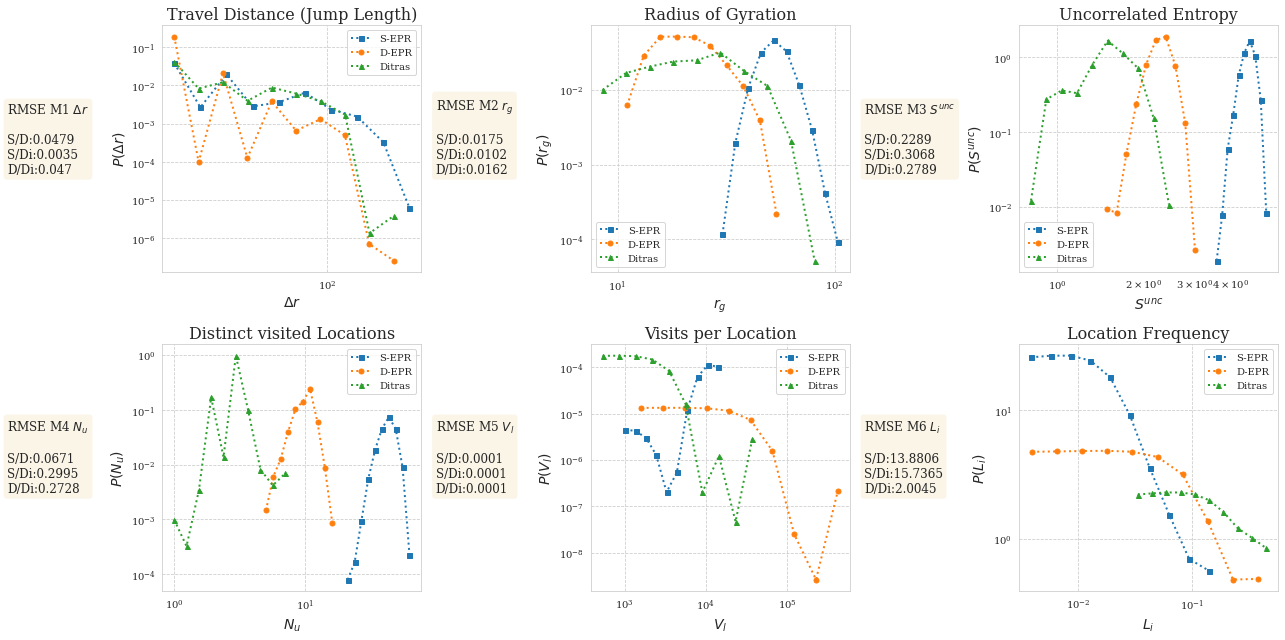

In [ ]:
plot_comparison(area_tessellation = 'a3_t2', n_agents = number_agents, show_real = show_real)

### **<font color="#4fffd9">2.3.3 AREA 3 - TESSELLATION 3</font>**

Building S-EPR model for Houston - official tessellation


100%|██████████| 5000/5000 [05:58<00:00, 13.93it/s]



S-EPR measures:
           M1       M2      M3       M4           M5      M6
Min   38.9581  40.3787  2.3434   7.0000   14648.0000  0.0118
Max  192.8321  75.5088  3.2335  10.0000  160760.0000  0.2085
Avg   77.0493  61.0659  2.9679   9.0934  109940.0000  0.1011
Std   35.0282   4.9150  0.1049   0.3204   36726.7504  0.0599

Building D-EPR model for Houston - official tessellation


100%|██████████| 5000/5000 [05:44<00:00, 14.51it/s]



D-EPR measures:
           M1       M2      M3      M4           M5      M6
Min   38.9581  36.3228  1.5740   4.000   12402.0000  0.0054
Max  192.8321  63.8499  2.7630  10.000  417301.0000  0.3796
Avg   73.1545  46.2995  2.1115   6.819  109940.0000  0.1021
Std   16.2111   3.7333  0.1671   1.018  134897.6098  0.1261

Building Ditras model for Houston - official tessellation


100%|██████████| 5000/5000 [01:03<00:00, 78.46it/s]



Ditras measures:
           M1       M2      M3      M4          M5      M6
Min   38.9581  16.8831  0.8113  1.0000   4730.0000  0.0417
Max  192.8321  83.9487  2.5161  7.0000  38449.0000  0.4669
Avg   72.3088  41.2908  1.5056  3.4018  11146.5000  0.1700
Std   21.3505   8.9412  0.2911  0.8180  10398.8562  0.1607

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



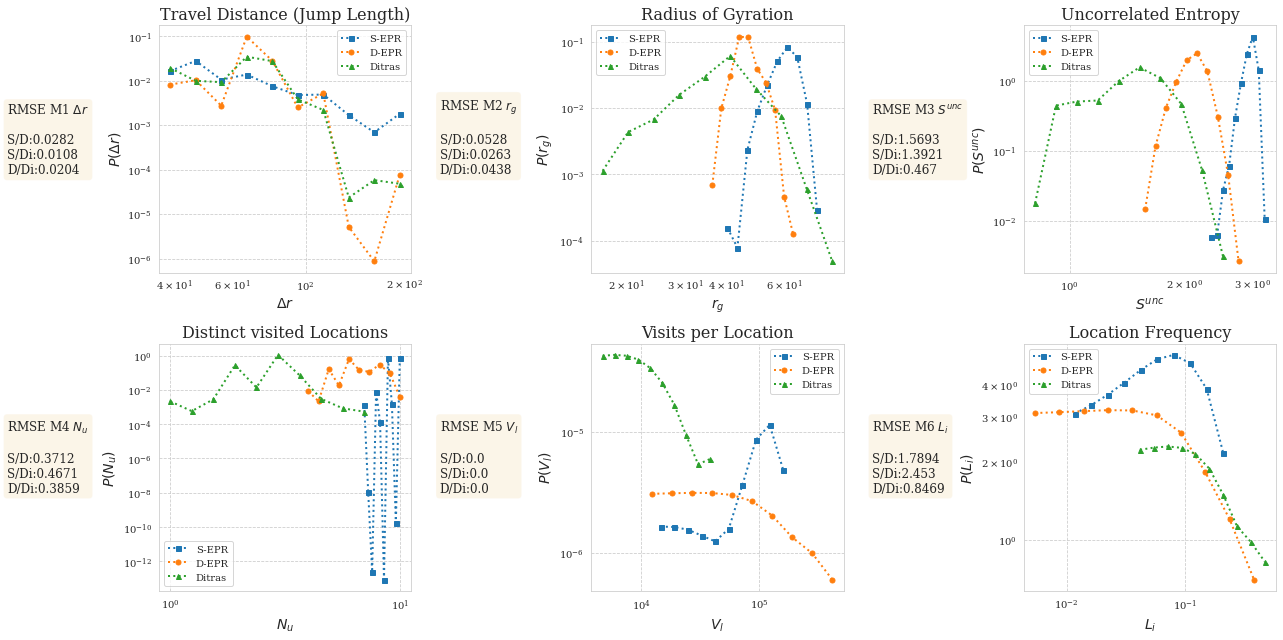

In [ ]:
plot_comparison(area_tessellation = 'a3_t3', n_agents = number_agents, show_real = show_real)

### **<font color="#4fffd9">2.3.4 AREA 3 - TESSELLATION 4</font>**

Building S-EPR model for Houston - voronoi tessellation


100%|██████████| 5000/5000 [05:57<00:00, 13.98it/s]



S-EPR measures:
           M1       M2      M3       M4           M5      M6
Min   20.7081  31.7474  2.7446  11.0000    7198.0000  0.0058
Max  193.7992  75.2604  3.7396  15.0000  109381.0000  0.1833
Avg   55.3249  45.7118  3.3983  13.7242   73190.6000  0.0673
Std   29.2549   5.3904  0.1428   0.6211   28097.6301  0.0520

Building D-EPR model for Houston - voronoi tessellation


100%|██████████| 5000/5000 [05:39<00:00, 14.71it/s]



D-EPR measures:
           M1       M2      M3       M4          M5      M6
Min   20.7081  21.5161  1.2660   4.0000    8932.000  0.0043
Max  193.7992  56.3104  2.6291  11.0000  461629.000  0.4206
Avg   49.0632  32.8938  2.0135   7.0742   73190.600  0.0930
Std   17.8210   5.4173  0.1846   1.0921  130116.707  0.1347

Building Ditras model for Houston - voronoi tessellation


100%|██████████| 5000/5000 [01:03<00:00, 79.26it/s]



Ditras measures:
           M1       M2      M3      M4          M5      M6
Min   20.7081  10.3180  0.8113  1.0000   3132.0000  0.0339
Max  193.7992  83.2728  2.4250  7.0000  44474.0000  0.4716
Avg   58.0007  33.1967  1.4276  3.1822   7511.0000  0.1686
Std   22.6256  10.2479  0.2703  0.7677  10601.5667  0.1691

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



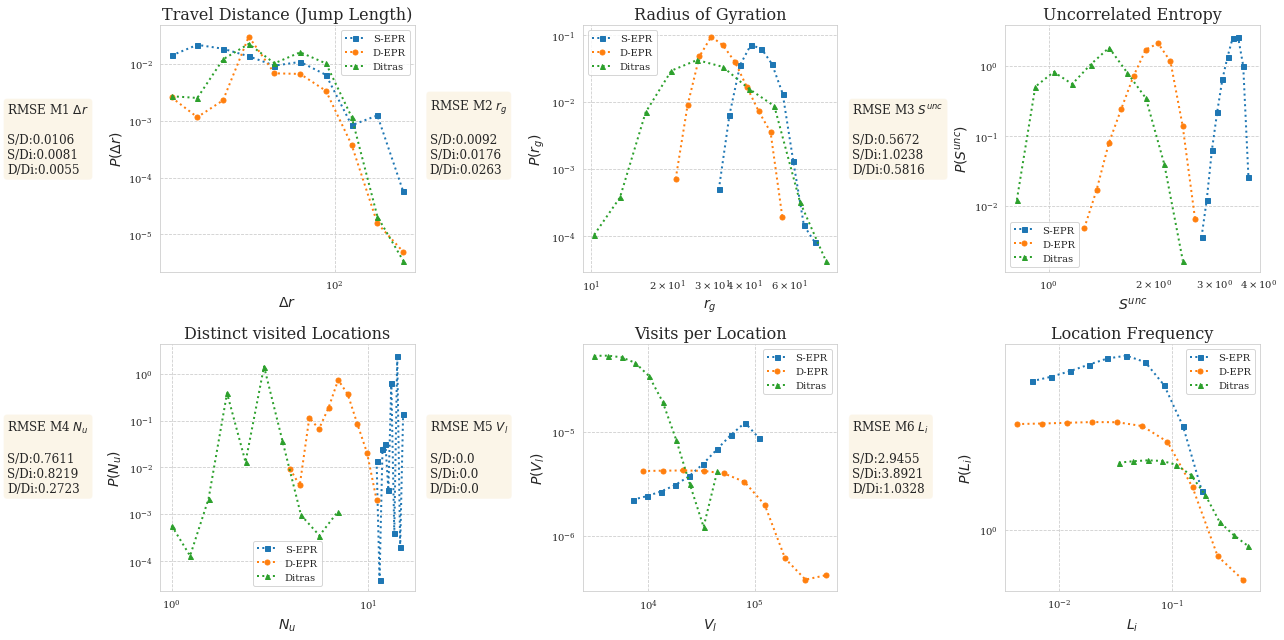

In [ ]:
plot_comparison(area_tessellation = 'a3_t4', n_agents = number_agents, show_real = show_real)

## **<font color="#84f745">2.4 AREA 4 - MEXICO CITY</font>**

### **<font color="#4fffd9">2.4.1 AREA 4 - TESSELLATION 1</font>**

Building S-EPR model for Mexico City - squared tessellation


100%|██████████| 5000/5000 [05:55<00:00, 14.05it/s]



S-EPR measures:
          M1       M2      M3       M4          M5      M6
Min   5.6466   9.4114  3.6126  21.0000   1567.0000  0.0039
Max  60.9113  23.0588  5.2111  52.0000  20952.0000  0.1441
Avg  16.9267  15.1941  4.4747  38.0120  16887.9385  0.0204
Std  10.6072   2.1166  0.2325   4.4833   3543.5283  0.0284

Building D-EPR model for Mexico City - squared tessellation


100%|██████████| 5000/5000 [05:58<00:00, 13.95it/s]



D-EPR measures:
          M1       M2      M3       M4           M5      M6
Min   5.6466   6.0752  2.8119  13.0000    2238.0000  0.0041
Max  45.5889  14.2542  4.1830  28.0000  162619.0000  0.1831
Avg  11.3804   9.3065  3.6223  19.7610   24440.5556  0.0371
Std   5.9702   1.2676  0.2088   2.1849   34868.6078  0.0474

Building Ditras model for Mexico City - squared tessellation


100%|██████████| 5000/5000 [01:35<00:00, 52.58it/s]



Ditras measures:
          M1       M2      M3       M4          M5      M6
Min   5.6466   2.9606  1.1432   3.0000   1880.0000  0.0130
Max  44.1570  17.8724  3.5659  16.0000  30441.0000  0.3547
Avg  12.3234   8.6021  2.4114   8.4726   6266.3556  0.0705
Std   6.8696   2.5240  0.3276   1.8461   6245.2244  0.0972

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



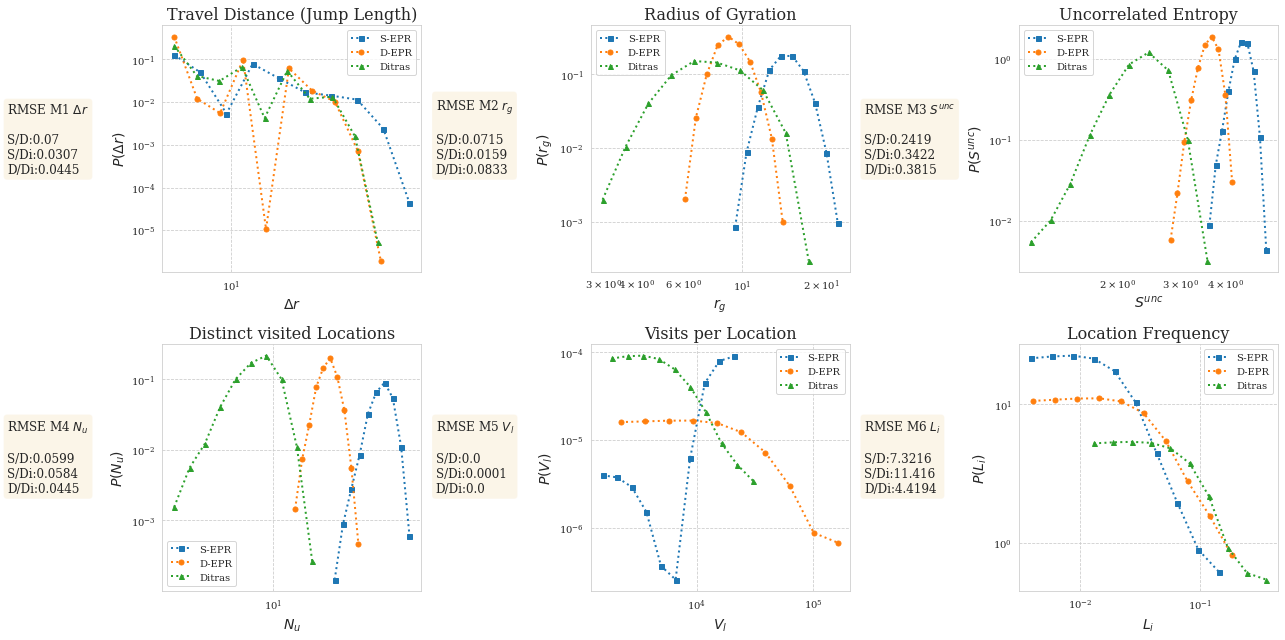

In [ ]:
plot_comparison(area_tessellation = 'a4_t1', n_agents = number_agents, show_real = show_real)

### **<font color="#4fffd9">2.4.2 AREA 4 - TESSELLATION 2</font>**

Building S-EPR model for Mexico City - hexagonal tessellation


100%|██████████| 5000/5000 [06:05<00:00, 13.70it/s]



S-EPR measures:
          M1       M2      M3       M4          M5      M6
Min   6.8911   8.8172  3.3963  19.0000   1627.0000  0.0037
Max  56.6268  21.6192  4.9561  43.0000  31760.0000  0.1474
Avg  17.1454  15.0591  4.3286  32.9968  23392.8723  0.0242
Std  10.0982   1.8814  0.2172   3.4448   5736.6769  0.0314

Building D-EPR model for Mexico City - hexagonal tessellation


100%|██████████| 5000/5000 [05:58<00:00, 13.96it/s]



D-EPR measures:
          M1       M2      M3       M4           M5      M6
Min   6.8943   5.8706  2.6499  11.0000    2456.0000  0.0046
Max  45.1977  14.3681  4.0630  23.0000  195511.0000  0.1954
Avg  11.8435   9.4635  3.4765  16.7404   33357.6061  0.0449
Std   5.7870   1.2071  0.1865   1.6848   41882.9966  0.0522

Building Ditras model for Mexico City - hexagonal tessellation


100%|██████████| 5000/5000 [01:37<00:00, 51.32it/s]



Ditras measures:
          M1       M2      M3       M4          M5      M6
Min   6.8943   3.6995  1.2371   3.0000   2344.0000  0.0167
Max  45.1977  17.9474  3.5011  14.0000  38674.0000  0.3571
Avg  12.6825   8.7438  2.3707   8.0762   8499.3333  0.0792
Std   6.6392   2.4462  0.3132   1.7159   7736.3688  0.1024

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



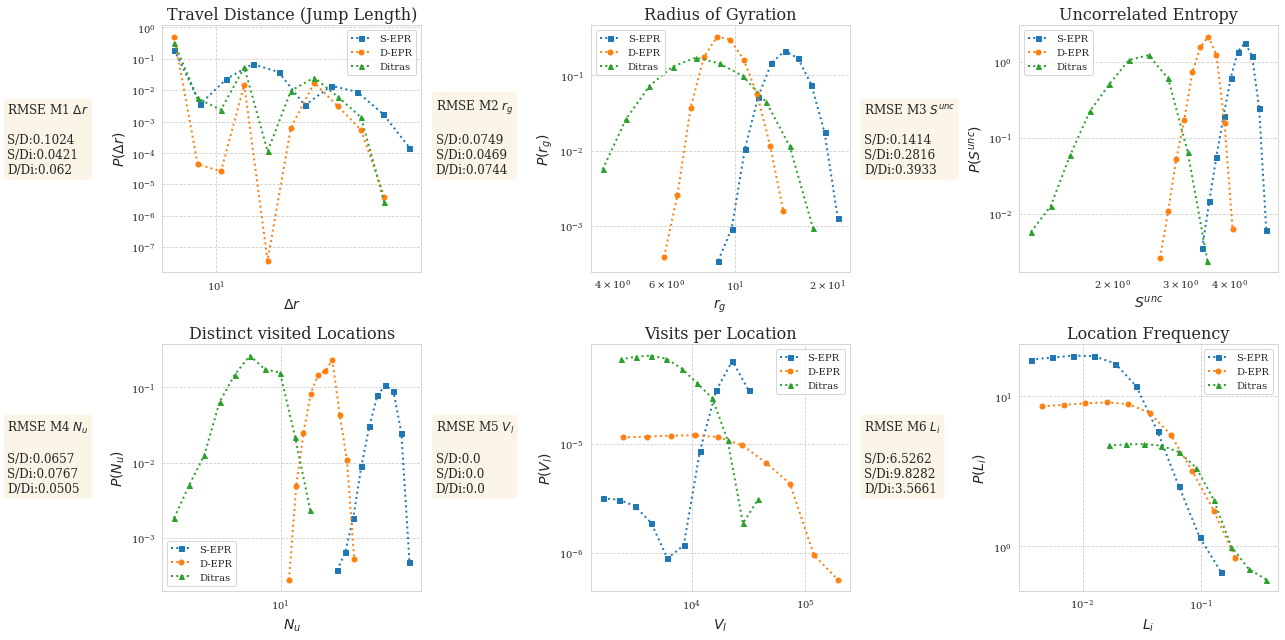

In [ ]:
plot_comparison(area_tessellation = 'a4_t2', n_agents = number_agents, show_real = show_real)

### **<font color="#4fffd9">2.4.3 AREA 4 - TESSELLATION 3</font>**

Building S-EPR model for Mexico City - official tessellation


100%|██████████| 5000/5000 [05:55<00:00, 14.08it/s]



S-EPR measures:
          M1       M2      M3       M4           M5      M6
Min   3.7362   6.3094  2.7862  11.0000    6892.0000  0.0055
Max  41.1062  16.3249  3.8669  16.0000  114461.0000  0.1799
Avg  12.9205  10.6452  3.4520  14.5884   68647.2500  0.0631
Std   7.0046   1.5309  0.1637   0.7903   28656.7546  0.0511

Building D-EPR model for Mexico City - official tessellation


100%|██████████| 5000/5000 [05:49<00:00, 14.32it/s]



D-EPR measures:
          M1       M2      M3       M4          M5      M6
Min   3.7362   5.8664  2.4693   9.0000    6252.000  0.0045
Max  41.1062  14.9264  3.6511  16.0000  190558.000  0.2059
Avg  11.9586   9.4321  3.1695  12.9352   68647.250  0.0636
Std   6.0737   1.4524  0.1728   1.1709   55871.032  0.0631

Building Ditras model for Mexico City - official tessellation


100%|██████████| 5000/5000 [01:36<00:00, 51.97it/s]



Ditras measures:
          M1       M2      M3       M4         M5      M6
Min   3.7362   3.0900  1.1586   3.0000   5651.000  0.0155
Max  41.1062  19.4294  3.2938  13.0000  39481.000  0.3664
Avg  12.6237   8.5839  2.2607   7.1744  17374.500  0.0852
Std   6.6135   2.6259  0.2990   1.4689  10129.298  0.1082

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



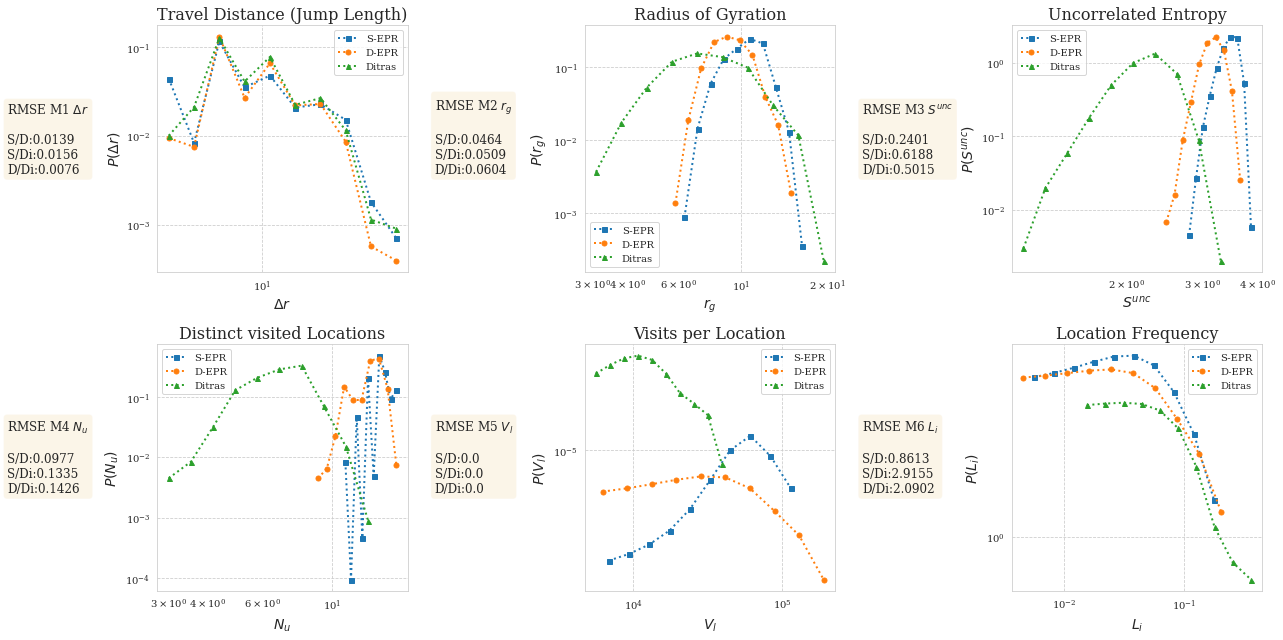

In [ ]:
plot_comparison(area_tessellation = 'a4_t3', n_agents = number_agents, show_real = show_real)

### **<font color="#4fffd9">2.4.4 AREA 4 - TESSELLATION 4</font>**

Building S-EPR model for Mexico City - voronoi tessellation


100%|██████████| 5000/5000 [05:55<00:00, 14.05it/s]



S-EPR measures:
          M1       M2      M3       M4          M5      M6
Min   2.5499   4.3898  3.0683  14.0000   4030.0000  0.0042
Max  46.4807  16.6334  4.4088  27.0000  75272.0000  0.1593
Avg   9.8453   8.5200  3.8926  21.8786  40753.3704  0.0380
Std   6.7155   2.1896  0.1977   2.1626  19136.4654  0.0404

Building D-EPR model for Mexico City - voronoi tessellation


100%|██████████| 5000/5000 [05:51<00:00, 14.21it/s]



D-EPR measures:
          M1       M2      M3       M4           M5      M6
Min   2.5499   4.7774  2.8560  11.0000    4062.0000  0.0039
Max  46.4807  15.7505  4.2148  24.0000  133932.0000  0.1804
Avg  10.0653   8.2870  3.5337  17.6004   40753.3704  0.0429
Std   5.5990   1.3569  0.1972   1.9748   38931.5922  0.0498

Building Ditras model for Mexico City - voronoi tessellation


100%|██████████| 5000/5000 [01:34<00:00, 52.94it/s]



Ditras measures:
          M1       M2      M3       M4          M5      M6
Min   2.5499   2.0621  1.1151   3.0000   3503.0000  0.0164
Max  43.7257  18.6149  3.4848  15.0000  25623.0000  0.3597
Avg  10.4490   7.3310  2.3760   8.1782  10309.4815  0.0749
Std   6.3278   2.5604  0.3200   1.7892   6665.1523  0.1004

---------------------------------------- MEASURES DISTRIBUTIONS PLOT ----------------------------------------



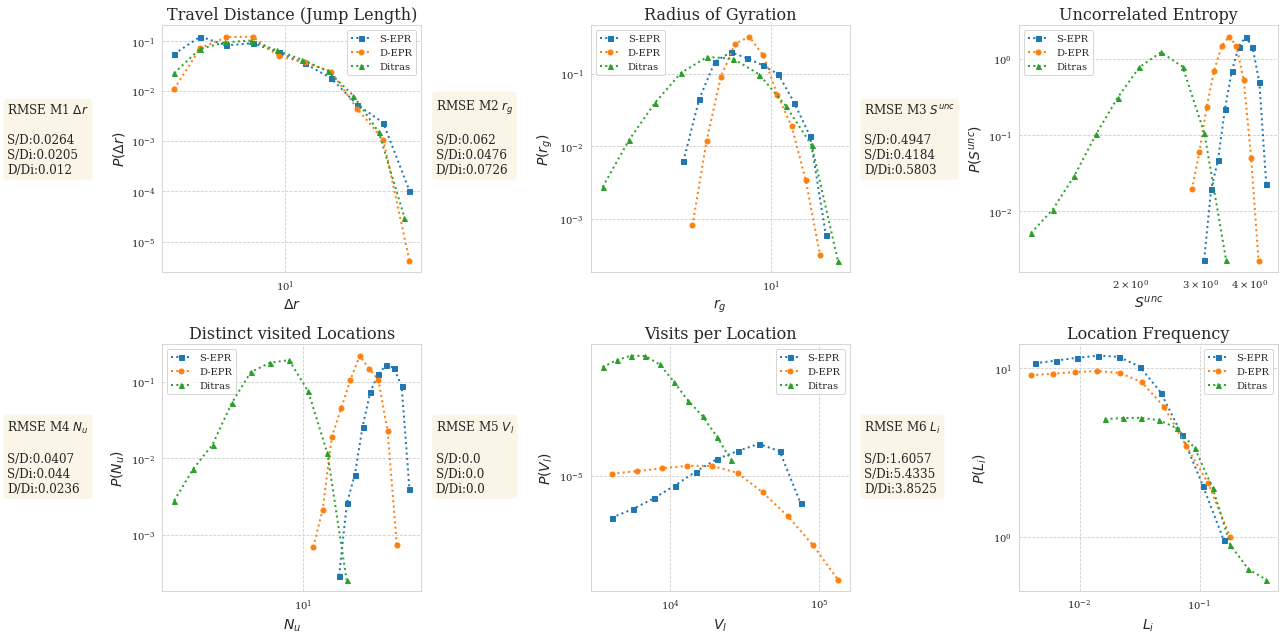

In [ ]:
plot_comparison(area_tessellation = 'a4_t4', n_agents = number_agents, show_real = show_real)